In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import math

import plotly.express as px

import pandas_datareader.data as web

from keras.callbacks import EarlyStopping

import keras
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.metrics import mean_squared_error

Using Theano backend.


## Introduction
Technical analysis is a trading discipline used to evaluate investments and identify trading opportunities in price trends and patterns from graphs.  Technical analysts believe past trading activity and price changes of a stock can be indicators of the security's future price movements.  The difference between 
technical analysis and fundamental analysis is that fundamental analysts focuses on a company's financials rather than historical price patterns or stock trends.  https://www.investopedia.com/terms/t/technicalanalysis.asp<br>
This notebook will demonstrate how to perform a basic technical analysis of stock prices using Python code.  I will provide analysis and insights of stock prices that can be obtained from historical stock data and corresponding graphs.  In addition, this notebook will demonstrate how algorithmic trading can be used to predict stock prices and how technical indicators can used with LTSM models.<br>
I obtained the historical stock data by using the Pandas library DataReader.  The library provides price and volume information regarding stocks. I will use mainly the Adjusted Closing Price ('Adj Close') from the datasets.<br>
In addition, I will use the Long Short Term Memory (LSTM ) and SARIMA models to forecast the next day stock price.  I will use the calculations from the technical indicators for forecasting.  In addition, I will use  metrics to measure the performance of the models at predicting stock prices.  
The data will consist of the following pharmaceutical companies that are developing  COVID-19 vaccines: 
* Pfizer (PFE),
* Johnson & Johnson (JNJ)
* Moderna (MRNA)
* Novavax (NVAX) 
* BioNTech SE (BNTX)
* MERCK & Co. (MRK)

What are technical Indicators?  Technical indicators are quick methods or mathematical calculations based on the price, volume, or open interest of a security or contract used by traders who follow technical analysis. https://www.investopedia.com/terms/t/technicalindicator.asp Technical indicators are signals produced from the patterns observed in the movements of stock prices (high, low, open, close) and volumes.  These signals are in turn used to predict the future price movements. Techincal Indicators as used in this notebook will provide a historical price analysis  regarding volatility and trends of the stock.  Technical indicators are a fundamental part of technical analysis and are typically plotted as a chart pattern to try to predict the market trend.<br>
Some basic examples of technical indicators which I will cover are:
1. Simple Moving Averages (SMA)
2. Exponential Moving Averages (EMA)
3. Moving Average Convergence Divergence (MACD) Crossover Strategy
4. Relative Strength Index (RSI)

My technical analysis of the stock prices will focus on answering the following questions  which concern price trends, volatility and forecasting:
### Question 1: 
Can technical indicators provide an investor or trader with information to make a decision of whether to buy and sell stocks?<br>
**Answer**: Yes. 
Investment decisions are very complicted and require knowledge and consideration of many variables which are beyond the scope of this notebook.  Technical indicators are tools used by investors and traders to gain insights regarding the stock's history, volatility, trends and the direction the price may be headed.    I will use Moving Averages, price volatility, RSI and MACD crossover strategies to answer this question.  A question to always consider is what type of investment is being sought?  Are you looking for short investments with high returns or long term investment with consistent returns?<br>
<br>
**Model 1** A Simple Moving Average Plot with a rolling average of 10 and 50 days.<br> 
**Model 2**  An Exponential Moving Average Plot.<br>
**Model 3**  Exponential Moving Average Crossover Stratergy<br>
**Model 4**  Relative Strength Index Plot

### Question 2:
How well do LSTM algorithms perform when used to forecast future stocks prices?  I will contrast the performance of LSTM models with data from the above technical indicators.  I will use the RMSE metric to compare the models' performances?<br>
**Model 1** I will use a LTSM Neural Network to make a price prediction with only historical price data.<br>
**Model 2** LTSM model with technical indicators to predict and graph future stock prices.<br>
### Question 3:
Which trading algorithms perform better at predicting stocks prices, LTSM or ARIMA?  I will compare results of both algorithms.<br> 
**Answer:** <br>
**Model 1** is a SARIMA model.<br>


## Historical Stock Data

### Multiple Stocks Data (multi_stocks)

In [2]:
from datetime import date
today = date.today()
def multiple_stock_data(ticker=None, start=None, end=None, plot=True, stock_value=None):
    
    try:
        #stock = pdr.get_data_yahoo(ticker,start,end)
        data = {}
        for stock in ticker:
            data = web.DataReader(stock,'yahoo',start,end)[stock_value]
        df_1 = pd.DataFrame(data)#.reset_index()
        if plot==True:
            df_1.plot(figsize=(12,8))
            label_font = {'weight':'bold','size':18}
            plt.title("Historical Adjusted Price Data",fontdict=label_font)
            plt.xlabel('Dates')
            plt.ylabel('Stocks Prices')
            plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
        
        return df_1
     
    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


Symbols,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,26.653324,103.436539,25.400000,NaN,23.433638,NaN
2017-01-04,26.887548,103.266876,26.200001,NaN,23.619688,NaN
2017-01-05,27.146002,104.347321,26.400000,NaN,24.262403,NaN
2017-01-06,27.041008,103.847282,27.400000,NaN,24.042524,NaN
2017-01-09,27.032928,103.829422,28.400000,NaN,24.127094,NaN
...,...,...,...,...,...,...
2021-03-23,35.360001,160.350006,219.839996,136.520004,49.400002,100.110001
2021-03-24,35.610001,161.910004,200.240005,131.610001,48.790001,94.050003
2021-03-25,35.669998,161.970001,178.229996,133.330002,49.700001,95.129997


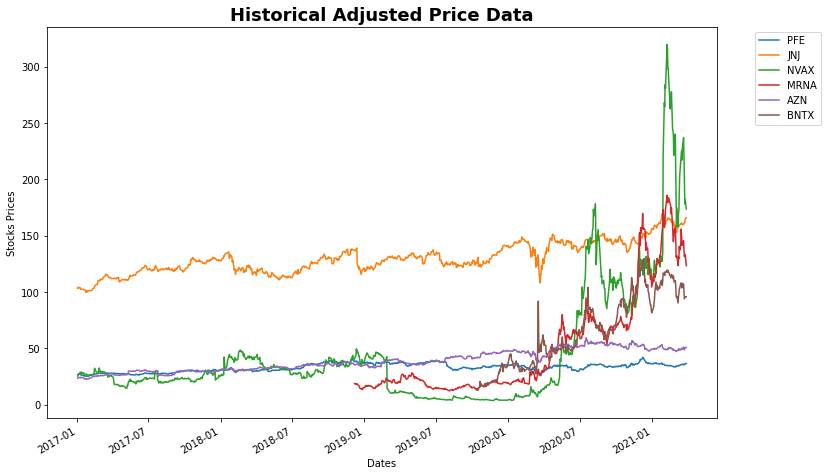

In [3]:
multi_stock_data = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='today',plot=True, stock_value='Adj Close')
multi_stock_data

In [4]:
multi_stock_data.to_csv('multi_pharm_data')

In [5]:
#start='2017',end='today'
multi_stocks = pd.read_csv('multi_pharm_data', parse_dates=True, index_col='Date')

#### Multiple Stock Plot

In [6]:
def multi_plot(df, stock_value=None):
    #plt.figure(figsize=(12,8))
    df.plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel(f'{stock_value} Price USD ($)',fontdict=label_font)
    plt.title(f'Historical {stock_value} Price',fontdict=label_font)            

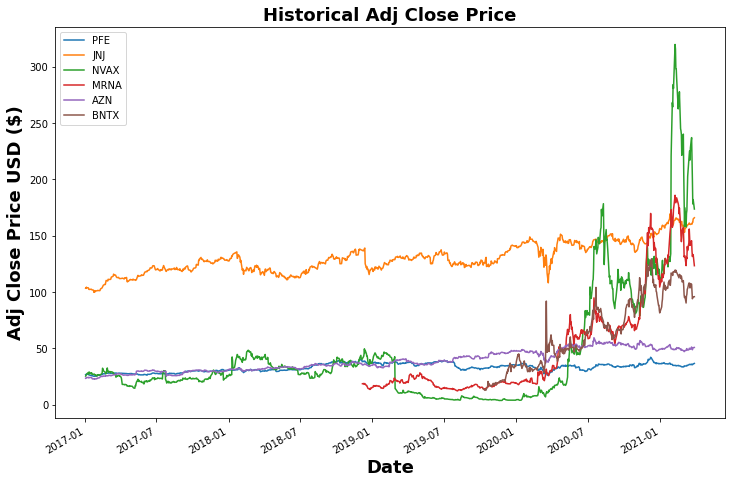

In [7]:
multi_plot(multi_stocks, stock_value='Adj Close')

In [8]:
multi_stocks.describe()

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
count,1066.000000,1066.000000,1066.000000,580.000000,1066.000000,369.000000
mean,32.900082,129.958427,44.185310,50.400991,38.679015,64.973577
std,3.677932,13.710939,52.209971,44.849503,9.166472,31.660130
min,25.159119,99.793396,3.690000,12.260000,22.596422,12.750000
25%,30.070993,120.284018,12.777500,17.882500,30.854332,36.700001
50%,33.239632,128.285149,27.200001,24.360001,36.458811,62.130001
75%,36.073600,139.848213,42.799999,69.824999,47.373898,92.000000
max,42.101986,169.423508,319.929993,185.979996,59.466022,129.539993


### Single Stock Data (pfe_stock_data)

In [9]:
def single_stock_data(symbol, start,end=None,plot=True,stock_value='Adj Close'):
    
    try:
        
        df = web.DataReader(symbol,'yahoo', start, end)
        df_single = pd.DataFrame(df)
        print("Dataframe has {} rows and {} columns".format(df_single.shape[0],df_single.shape[1]))
        print()
        if plot==True:
            plt.figure(figsize=(12,8))
            plt.plot(df_single[stock_value])
            label_font = {'weight':'bold','size':18}
            plt.xlabel('Date',fontdict=label_font)
            plt.ylabel('Close Price USD ($)',fontdict=label_font)
            plt.title(f'Historical {stock_value} Price for {symbol}',fontdict=label_font)
            #plot = go.Scatter(x=df_single.index, y=df_single['Adj Close'])
            
        return df_single
        
    except Exception as e:
        #if inccorect symbol is inputted, error message displayed
        print("Error occured/Incorrect Symbol:", e)
        #data = 'Incorrect Symbol'


This is data for Pfizer.

Dataframe has 1066 rows and 6 columns



,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,31.309298,30.920303,31.024668,31.309298,23391844.0,26.653324
2017-01-04,31.641365,31.337761,31.432638,31.584440,22753963.0,26.887548
2017-01-05,31.963947,31.423149,31.660341,31.888046,21083584.0,27.146002
2017-01-06,31.973434,31.631880,31.935484,31.764706,18418228.0,27.041008
2017-01-09,31.944971,31.669828,31.717268,31.755219,21559886.0,27.032928
...,...,...,...,...,...,...
2021-03-23,35.930000,35.320000,35.820000,35.360001,27970500.0,35.360001
2021-03-24,35.930000,35.369999,35.480000,35.610001,22883400.0,35.610001
2021-03-25,35.790001,35.250000,35.650002,35.669998,24875300.0,35.669998


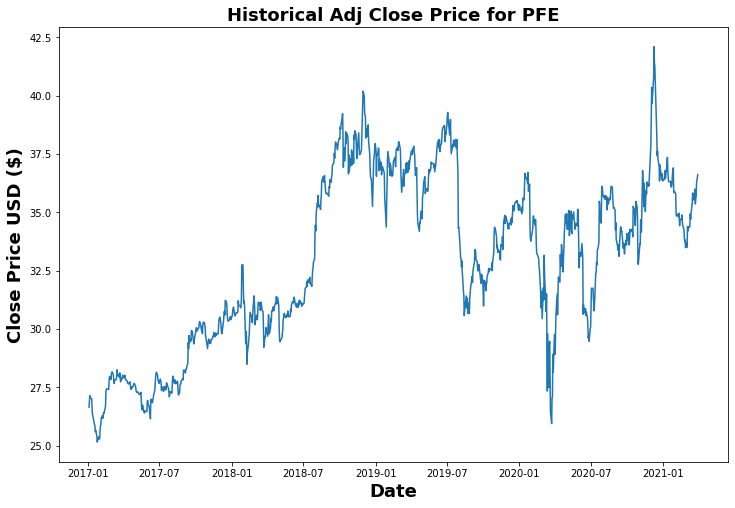

In [10]:
start='01-01-2017'
end='today'
pfe_stock = single_stock_data('PFE', start= start,end='today',plot=True,stock_value='Adj Close')
pfe_stock

In [11]:
pfe_stock.to_csv('pfe_stock')
pfe_stock_df = pd.read_csv('pfe_stock', parse_dates=True, index_col='Date')
#single_stock['Close']['2015-04-01':'2015-12-01'].plot()
pfe_stock_data = pfe_stock_df[['Close','Volume','Adj Close']]

In [12]:
pfe_stock_data.describe()

,Close,Volume,Adj Close
count,1066.000000,1.066000e+03,1066.000000
mean,35.580246,2.606633e+07,32.900082
std,3.284966,1.367817e+07,3.677932
min,27.030361,5.187683e+06,25.159119
25%,33.458254,1.816469e+07,30.070993
50%,34.853586,2.285842e+07,33.239632
75%,37.664649,2.952923e+07,36.073600
max,43.861481,2.301539e+08,42.101986


#### Single Stock Plot

In [13]:
def single_plot(df,stock_value=None, stock_symbol=None):
    df[stock_value].plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel(f'{stock_value} Price USD ($)',fontdict=label_font)
    plt.title(f'{stock_symbol} {stock_value} History',fontdict=label_font)                

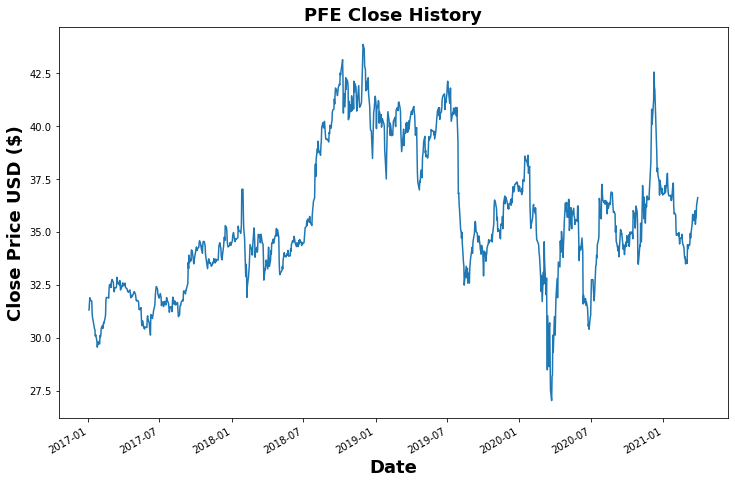

In [14]:
single_plot(pfe_stock_data, stock_value='Close', stock_symbol='PFE')

In [15]:
pfe_stock_data['Adj Close'].describe()

count    1066.000000
mean       32.900082
std         3.677932
min        25.159119
25%        30.070993
50%        33.239632
75%        36.073600
max        42.101986
Name: Adj Close, dtype: float64

## Technical Indicators
The practice of analyzing and executing stock trades is becoming increasingly automated with algorithimic trading.  The usage of technnical indicators is part of algorithmic trading. What are technical indicators and how are they used by Technical Analyst in stock trading?  Technical indicators are methods or pattern-based signals produced by the price, volume, and/or open interest of a stock which are used by traders who follow technical analysis.  Technical analysts believe past trading activity and price changes of a security can be valuable indicators of the security's future price movements. https://www.investopedia.com/terms/t/technicalindicator.asp<br>Technical analysts look for indicators in the historical data and use them to predict future price movements.  The analysts also use them to look for entry and exit points in markets to conduct trades.  I will discuss the below popular technical indicators which are used in the markets to study price movements:

1. Moving Averages (MA)
    > Simple Moving Average<br>
    > Exponential Moving Average<br>
2. Rate of Change (ROC)
3. Relative Strength Index (RSI)

### Moving Averages
The moving average is also known as the rolling mean or running average.  Moving averages smooth out the curve by filtering out the noise inorder to highlight components in the data such as trends and seasonality.  The moving average smooths out the variations in the dataset by calculating the moving average.  Two common types of moving averages are Simple Moving Average (SMA), and Exponential Moving Average (EMA). <br>

#### Simple Moving Average
The Simple Moving Average is the arithmetic mean of all the stock prices or the sum of all the stock prices divided by the number of periods.  We can use the Python rolling method to calculate moving averages.  SMA calculates the average of prices over a given interval of time and is used to determine the trend of the stock. Common time periods used for moving averages are 5, 10, 20, 50, 200 days.  A 10 time period SMA would mean 10 trading days.  In this case I am  considering the past 10 and 50 days and averaging each group, so there won't be any results for these begining entries.<br>  
The below graph pertains to Pfizer stock and looks like the stock price is volatile with lots of fluctuations and noise.  The plot shows the Adj Close price and 10 and 50-day moving averages.  The 10-day follows the Close price pretty closely but smooths out the positve and negative spikes in prices.  The 50-day eliminates most of the volatility.  The SMA smooths out the noise and gives a more accurate picture of how stock performs during volatile periods.<br><br><br>
I would like to highlight certain time periods that highllight how this stock has performed during volatile periods.  Aound 2/18, there was a spike in price from \\$35.00 to almost \\$37.50 and then dropped quickly to almost \\$32.00.  What is the SMA showing us?  SMA gives a more realistic picture of what happened with stock the price. The price increased and dropped precipitously.  We may not know what precipitated such activity, but what were the 10 and 50 day averages around this time period for a more accurate picture of what the stock price was for that period?  How does this compare to performance of the stock in general?  What's interesting is that if we do subsets of for time period of 2/18 to for 10 and 50 averages we can get closer look at what the averge price was.  The average price of the stock was \\$35.578751.  When applying 10 and 50-day the average price is still \\$35.  When I subset the data the average price was \\$34.015994.  When I applied the 10 and 50-day Moving Averages the average price is still a \\$34.052809 and \\$34.168457, respectively.  So is the stock price really that volatile? Not really. <br><br>
Around 8/2019, the price was pretty volatile.  

##### Moving Average Convergence/Divergence Cross Over Stategy
The MACD can be used for for various MAs.  Stock market analysts and investors use the Exponential Moving Average Crossover strategy to analyze price trends and predict upcoming change in trends.  A crossover occurs when a faster moving average (i.e. a shorter period moving average) crosses a slower moving average (i.e. a longer period moving average). In stock trading, this meeting point can be used as a potential indicator to buy or sell an asset. When the short term moving average crosses above the long term moving average, this indicates a buy signal. However, when the short term moving average crosses below the long term moving average, it may be a good moment to sell.  The 50-day moving average is the one that takes longer to adjust to sudden price changes, while the 10-day one is much faster to account for sudden changes.  In the code below I am defining buying and selling signals for the crossover strategy.
The logic of the strategy is as follows:
when the fast MA crosses the slow one upwards, we buy the asset.  When the slow MA crosses the fast one upwards, we sell the asset.
<br>
<br>
For example, around 5/18 there is a signal to puchase.  Around this time the stock was selling for around \\$34.00 per share.  If we had puchased it we could've sold shares around 10/8 for \\$42.00 per share and made a nice profit.  The MACD shows us where the previous trends were with price and potential for making and losing money.  The MACD shows that there is price volatility if looking for short-term investments.  Around 8/18 the price was around \\$41.00. The signal indicats to sell because there is an upcoming signicant drop in price around 9/18 to \\$32.50    

In [16]:
sma_func_calc = pd.read_csv('pfe_stock', parse_dates=True, index_col='Date')

In [17]:
def sma_function(data, col1=None, col2=None, col3=None, symbol=None):
    data[col2] = data[col1].rolling(10).mean()
    data[col3] = data[col1].rolling(50).mean()

    data['Signal'] = 0.0
    data['Signal'] = np.where(data[col2] > data[col3], 1.0, 0.0)
    data['Position'] = data['Signal'].diff()

    data = data.dropna()
    
    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    data[col1].plot(color = 'blue', label= 'Close Price',alpha=0.5) 
    data[col2].plot(color = 'red',label = '10-day SMA') 
    data[col3].plot(color = 'green', label = '50-day SMA')
    label_font = {'weight':'bold','size':18}
    plt.title(f'{symbol} Smooth Moving Average',fontdict=label_font)
    plt.ylabel('Stock Price', fontsize = 15,fontdict=label_font)
    plt.xlabel('Date',fontdict=label_font)
    plt.legend(loc='best',fontsize=14)

    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    data[col1].plot(color = 'blue', label= 'Close Price',alpha=0.5) 
    data[col2].plot(color = 'red',label = col2) 
    data[col3].plot(color = 'green', label = col3)
    # plot ‘buy’ signals
    plt.plot(data[data['Position'] == 1].index, 
             data[col2][data['Position'] == 1], 
             '^', markersize = 10, color = 'green', label = 'buy')
    # plot ‘sell’ signals
    plt.plot(data[data['Position'] == -1].index, 
             data[col2][data['Position'] == -1], 
             'v', markersize = 10, color = 'red', label = 'sell')
    
    plt.ylabel('Stock Price', fontsize = 15,fontdict=label_font)
    plt.xlabel('Date',fontdict=label_font)
    plt.title(f'{symbol} SMA Crossover Stategy',fontdict=label_font)
    plt.legend(loc='best',fontsize=14)
    plt.grid()
    plt.show()
        
    return data

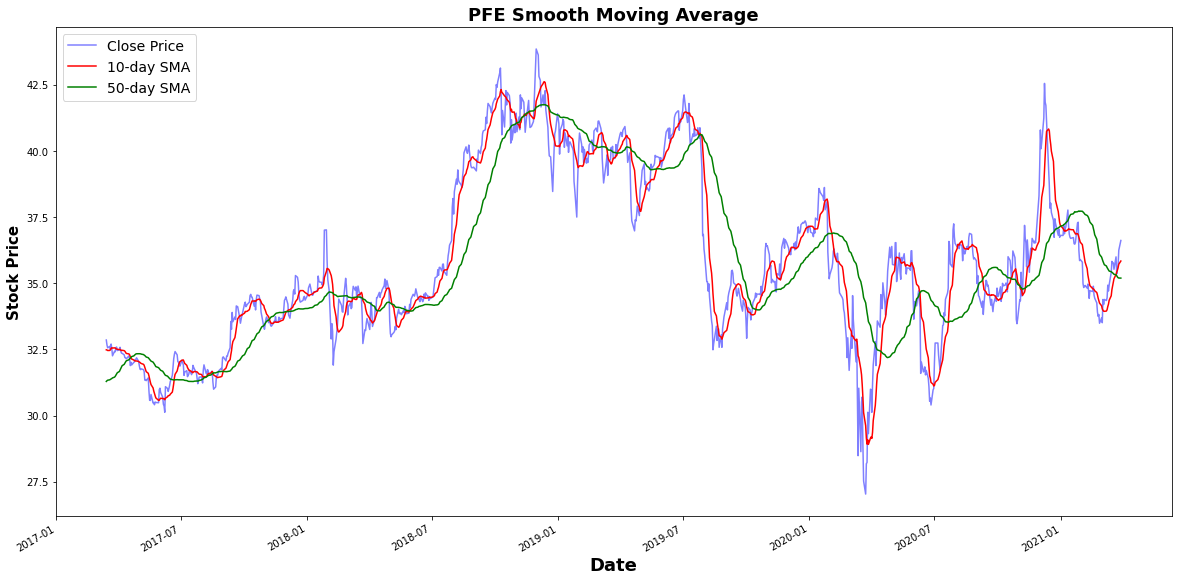

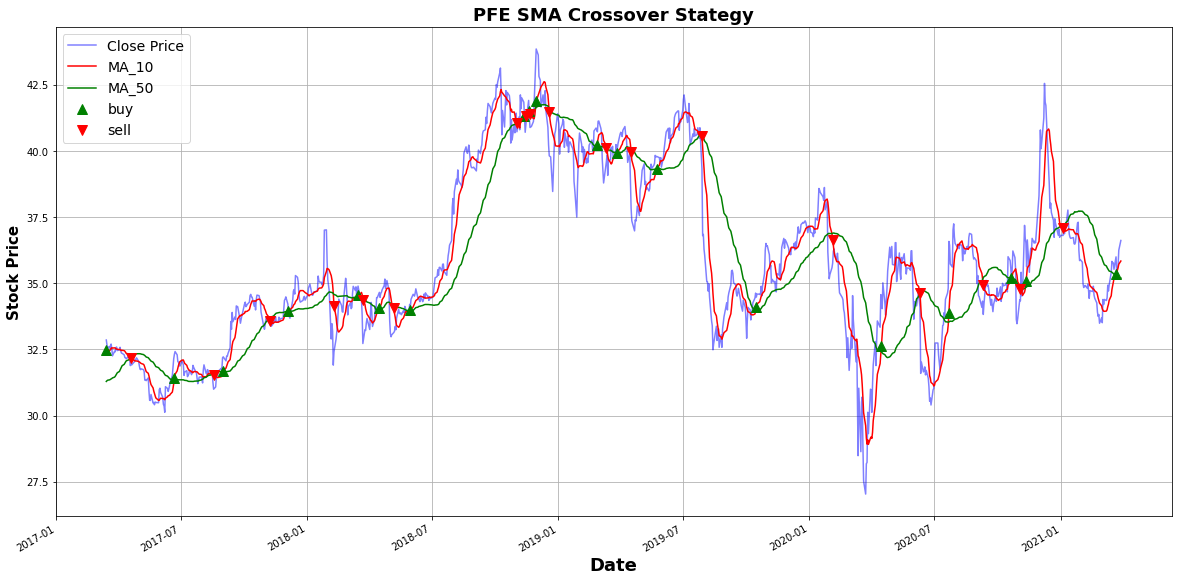

,High,Low,Open,Close,Volume,Adj Close,MA_10,MA_50,Signal,Position
Date,,,,,,,,,,
2017-03-15,32.922199,32.428844,32.466793,32.855785,24279839.0,28.254789,32.485769,31.289754,1.0,1.0
2017-03-16,32.855785,32.495255,32.798862,32.666035,21816219.0,28.091606,32.478179,31.316888,1.0,0.0
2017-03-17,32.808350,32.514233,32.694496,32.561668,45736117.0,28.001856,32.459203,31.336433,1.0,0.0
2017-03-20,32.732449,32.561668,32.637569,32.618595,18435514.0,28.050808,32.462049,31.351044,1.0,0.0
2017-03-21,32.836811,32.428844,32.713470,32.495255,33083479.0,27.944742,32.486717,31.365655,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-03-23,35.930000,35.320000,35.820000,35.360001,27970500.0,35.360001,35.427000,35.285800,1.0,0.0
2021-03-24,35.930000,35.369999,35.480000,35.610001,22883400.0,35.610001,35.495000,35.242600,1.0,0.0
2021-03-25,35.790001,35.250000,35.650002,35.669998,24875300.0,35.669998,35.591000,35.212400,1.0,0.0


In [18]:
sma_data = sma_function(sma_func_calc,col1='Close',col2='MA_10',col3='MA_50',symbol='PFE')
sma_data

In [19]:
sma_data[['Close','MA_10','MA_50']].describe()

,Close,MA_10,MA_50
count,1017.000000,1017.000000,1017.000000
mean,35.788506,35.772743,35.705565
std,3.212182,3.155640,2.960424
min,27.030361,28.910816,31.284440
25%,33.681213,33.752372,33.917078
50%,34.971539,34.912000,34.851802
75%,38.273247,38.253000,37.669951
max,43.861481,42.622391,41.757495


#### SMA Subset

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

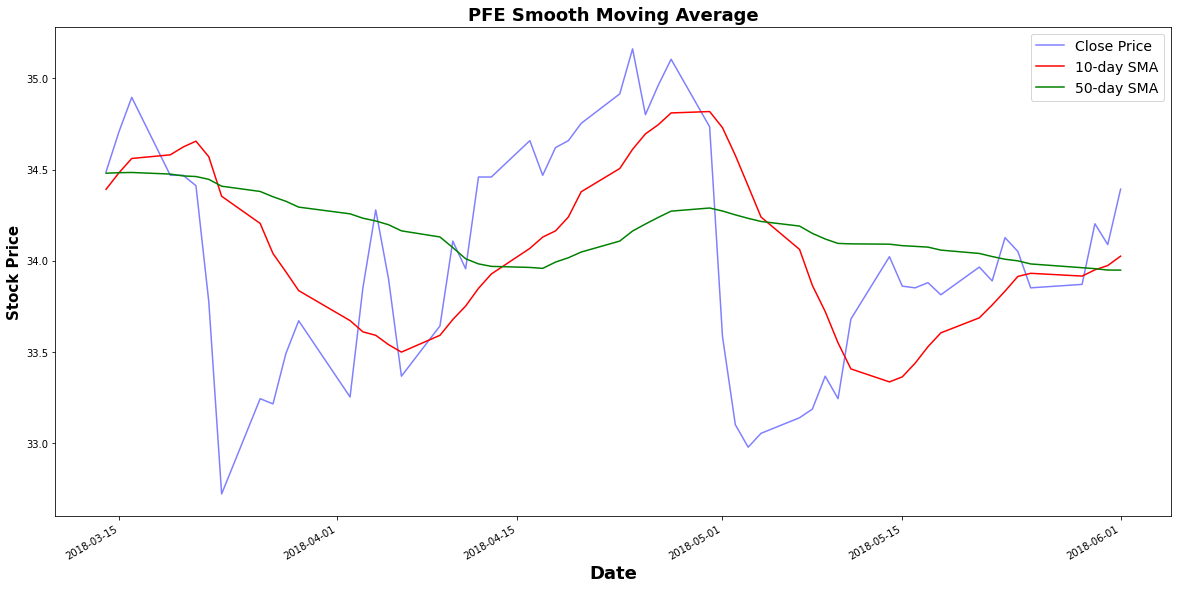

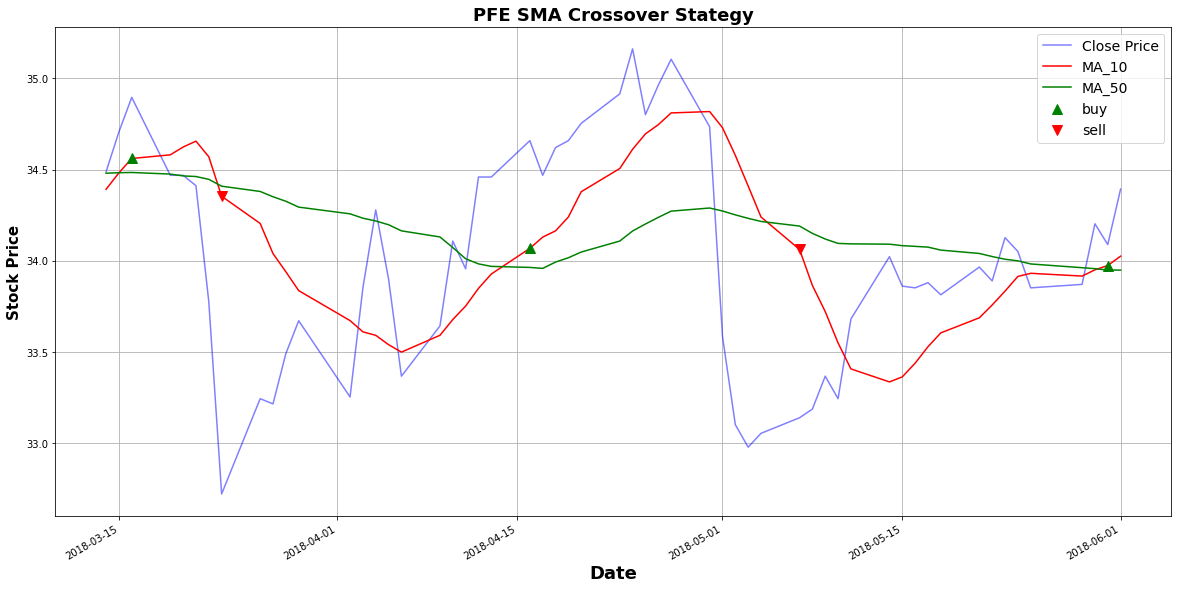

In [20]:
sma_rolling_3 = sma_function(sma_func_calc['2018-01-01':'2018-06-01'],col1='Close',col2='MA_10',col3='MA_50',symbol='PFE')
sma_rolling_3;

In [21]:
print('Close Price')
print(sma_rolling_3['Close'].describe())
print()
print('10 Day Moving Average')
print(sma_rolling_3['MA_10'].describe())
print()
print('50 Day Moving Average')
print(sma_rolling_3['MA_50'].describe())

Close Price
count    56.000000
mean     34.015994
std       0.607358
min      32.722961
25%      33.629033
50%      33.961100
75%      34.468693
max      35.161289
Name: Close, dtype: float64

10 Day Moving Average
count    56.000000
mean     34.052809
std       0.430600
min      33.336811
25%      33.685484
50%      33.962524
75%      34.427893
max      34.817837
Name: MA_10, dtype: float64

50 Day Moving Average
count    56.000000
mean     34.168457
std       0.166282
min      33.949146
25%      34.021869
50%      34.140607
75%      34.272486
max      34.484061
Name: MA_50, dtype: float64


#### Exponential Moving Average (EMA)
 The EMA is also referred to as the exponentially weighted moving average.  The difference between EMA and SMA is that SMA assigns equal weight to all periods.  Whereas, with EMA the latest prices are given higher weights and it assigns lesser weight to past data.  EMA is used more by short term traders because it is quicker to react to price changes compared to SMA which is slower. This technical indicator is used to produce buy and sell signals based on crossovers and divergences from the historical price average.  https://www.investopedia.com/terms/e/ema.asp
 <br>

#### MACD Crossover
Short term moving average usually last 12 periods and long term last 26 periods.  The Signal line is generally a 9 period exponentially smooth average of the MACD line.  This indicator uses two (or more) moving averages — a faster moving average (short-term) and a slower (long-term) moving average.  This program uses the MACD Crossover to determine when to buy and sell stocks.<br>
A short term moving average is faster because it only considers prices over short period of time and is thus more reactive to daily price changes.  Whereas, a long-term moving average is deemed slower as it encapsulates prices over a longer period and a slower response to daily prices.<br>
The MACD line is calculated by taking the short term exponenrial moving average minus the long term exponetial moving average.  When the red line crosses above the green line you see an increase in the price and every time the red drops below the EMA26 you see the price decrease.<br>When MACD line crosses above the signal line that indicates a good time to buy and when it is below signal line that indcates a time to sell.

In [22]:
macd_df_1 = pfe_stock_data.copy()

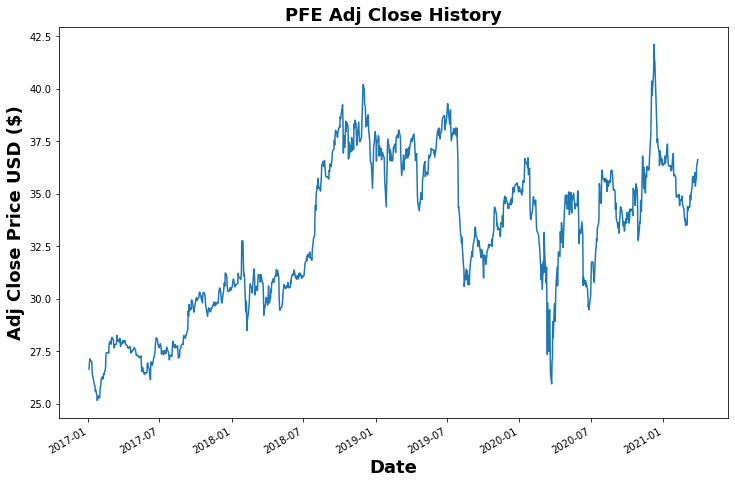

In [23]:
#ema_function(macd_df)
single_plot(macd_df_1, stock_value='Adj Close', stock_symbol='PFE')

#### Exponential Moving Average Crossover Stratergy
Stock market analysts and investors use Exponential Moving Average Crossover strategy, among other moving averages, to analyze price trends and predict upcoming change of trends.  A moving-average crossover occurs when plotting, the two moving averages each based on different time-periods tend to cross. This indicator uses two (or more) moving averages — a faster moving average (short-term) and a slower (long-term) moving average. The faster moving average may be 5-, 10- or 25-day period while the slower moving average can be 50-, 100- or 200-day period.  A short term moving average is faster because it only considers prices over short period of time and is thus more reactive to daily price changes. On the other hand, a long-term moving average is deemed slower as it encapsulates prices over a longer period and is more lethargic.<br>
A crossover occurs when a faster moving average (i.e. a shorter period moving average) crosses a slower moving average (i.e. a longer period moving average). In stock trading, this meeting point can be used as a potential indicator to buy or sell an asset.
When the short term moving average crosses above the long term moving average, this indicates a buy signal.
However, when the short term moving average crosses below the long term moving average, it may be a good moment to sell.<br>

In [24]:
ewmal_2 = pfe_stock_data.copy() 

In [25]:
def ema_function(data, span1=None,span2=None):    
    # Create 20 days exponential moving average column
    data['12_EMA'] = data['Close'].ewm(span = span1, adjust = False).mean()
    # Create 50 days exponential moving average column
    data['26_EMA'] = data['Close'].ewm(span = span2, adjust = False).mean()

    #create a new column 'Signal' such that if 20-day EMA is greater   # than 50-day EMA then set Signal as 1 else 0
    data['Signal'] = 0.0  
    data['Signal'] = np.where(data['12_EMA'] > data['26_EMA'], 1.0, 0.0)

    # create a new column 'Position' which is a day-to-day difference of # the 'Signal' column
    data['Position'] = data['Signal'].diff()

    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    data['Close'].plot(color = 'b', label= 'Close Price') 
    data['12_EMA'].plot(color = 'r',label = '12-day EMA') 
    data['26_EMA'].plot(color = 'g', label = '26-day EMA')

    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    data['Close'].plot(color = 'b', label= 'Close Price') 
    data['12_EMA'].plot(color = 'r',label = '12-day EMA') 
    data['26_EMA'].plot(color = 'g', label = '26-day EMA')
    # plot ‘buy’ signals
    plt.plot(data[ewmal_2['Position'] == 1].index, 
             data['12_EMA'][ewmal_2['Position'] == 1], 
             '^', markersize = 15, color = 'g', label = 'buy')
    # plot ‘sell’ signals
    plt.plot(data[data['Position'] == -1].index, 
             data['12_EMA'][data['Position'] == -1], 
             'v', markersize = 15, color = 'r', label = 'sell')
    plt.ylabel('Stock Price', fontsize = 15 )
    plt.xlabel('Date', fontsize = 15 )
    plt.title('Pfizer EWMA Crossover', fontsize = 20)
    plt.legend()
    plt.grid()
    
    return data

,Close,Volume,Adj Close,12_EMA,26_EMA,Signal,Position
Date,,,,,,,
2017-01-03,31.309298,23391844.0,26.653324,31.309298,31.309298,0.0,NaN
2017-01-04,31.584440,22753963.0,26.887548,31.351627,31.329679,1.0,1.0
2017-01-05,31.888046,21083584.0,27.146002,31.434153,31.371039,1.0,0.0
2017-01-06,31.764706,18418228.0,27.041008,31.485007,31.400200,1.0,0.0
2017-01-09,31.755219,21559886.0,27.032928,31.526578,31.426497,1.0,0.0
...,...,...,...,...,...,...,...
2021-03-23,35.360001,27970500.0,35.360001,35.296599,35.095296,1.0,0.0
2021-03-24,35.610001,22883400.0,35.610001,35.344814,35.133422,1.0,0.0
2021-03-25,35.669998,24875300.0,35.669998,35.394843,35.173169,1.0,0.0


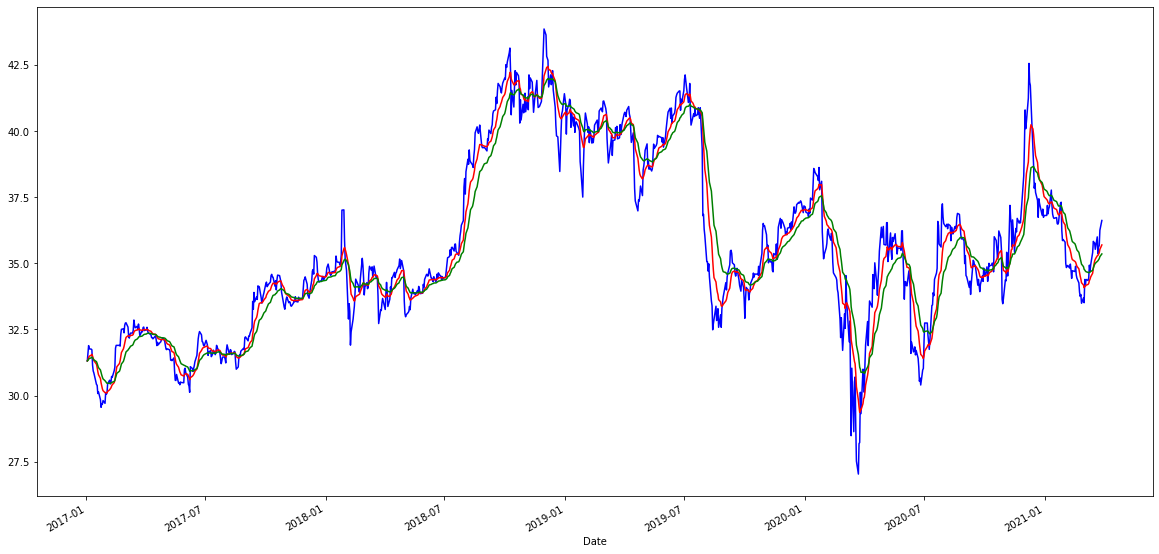

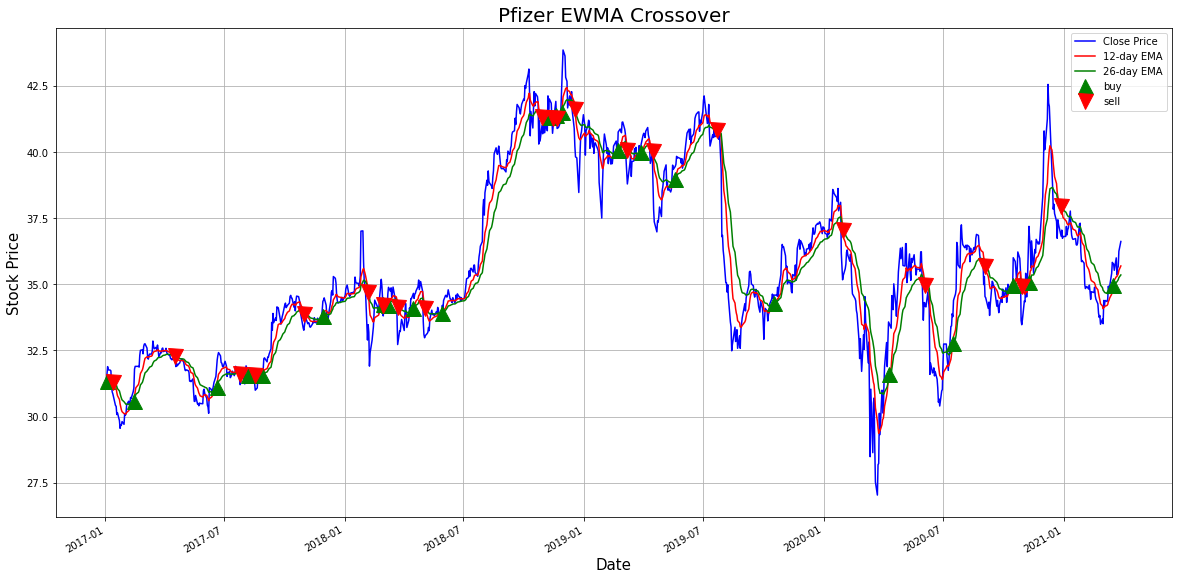

In [26]:
ewm_calc = ema_function(ewmal_2,span1 = 12,span2 = 26)
ewm_calc

In [27]:
#ewm_calc.head()

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



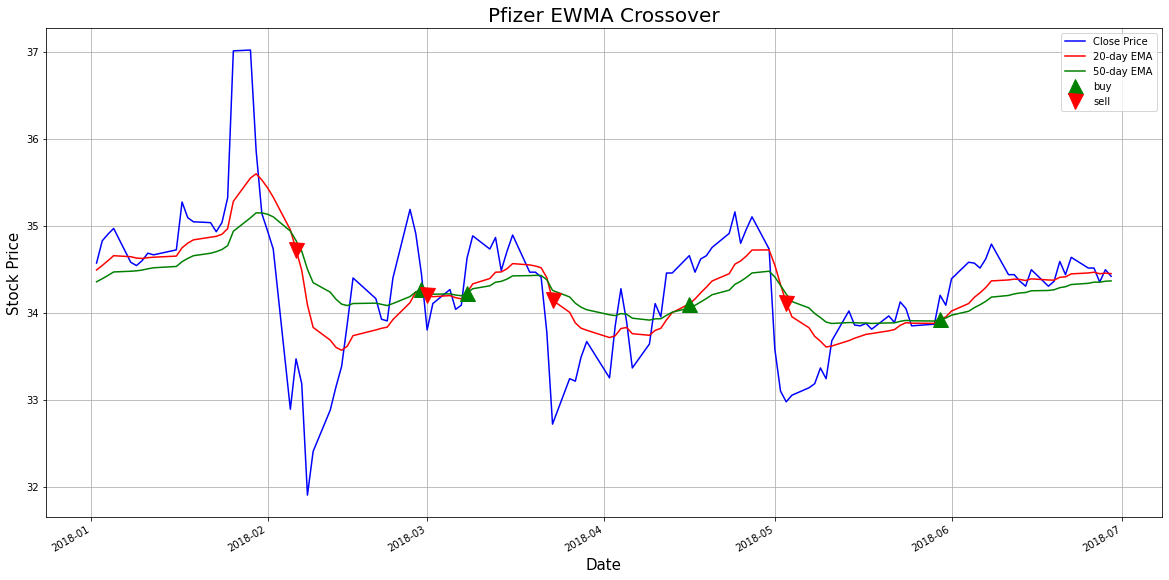

In [28]:
ewmal_3 = ewmal_2['2018-01-01':'2018-07-01']
plt.figure(figsize = (20,10))
# plot close price, short-term and long-term moving averages 
ewmal_3['Close'].plot(color = 'b', label= 'Close Price') 
ewmal_3['12_EMA'].plot(color = 'r',label = '20-day EMA') 
ewmal_3['26_EMA'].plot(color = 'g', label = '50-day EMA')
# plot ‘buy’ signals
plt.plot(ewmal_3[ewmal_2['Position'] == 1].index, 
         ewmal_3['12_EMA'][ewmal_2['Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(ewmal_3[ewmal_3['Position'] == -1].index, 
         ewmal_3['12_EMA'][ewmal_3['Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Stock Price', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Pfizer EWMA Crossover', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

### Rate of Change
The Rate of Change (ROC) is a technical indicator that measures the percentage change between the most recent price and the price a specified number of days before. The indicator fluctuates around the zero line.
#### Historical Price Change Analysis
Volatility is the range of price changes a security experiences over a given period of time. If the price stays relatively stable, the security has low volatility. A highly volatile security hits new highs and lows quickly, moves erratically, and has rapid increases and dramatic falls.  Is volatility in price good or bad for trading? This is a complex question with multiple possible answer.  One possible answer is that as the price fluctuates, it provides the opportunity for investors to buy stock in a solid company when the price is very low, and then wait for cumulative growth down the road.  https://www.investopedia.com/ask/answers/010915/volatility-good-thing-or-bad-thing-investors-point-view-and-why.asp<br>
For short-term traders, volatility is even more crucial. Day traders work with changes that occur second-to-second, minute-to-minute. If there is no price change, there is no profit.https://www.investopedia.com/ask/answers/010915/volatility-good-thing-or-bad-thing-investors-point-view-and-why.asp The graph shows that the data points are now centered aound 0. The graph shows that around 3/20 was a volatile period for the stock price and it increase above 7% and decreased 7%.



### Price Change in Dollars
To see how big the changes in price were on a daily basis we subtract yesterday's closing price yesterday from today.  This will show the change in price.  A column named 'Actual_Changes' is added to calculate actual change in dollars.<br>For example, we can see that on 1/3/17 the Adj Closing price was 26.653324 and on 1/4/17 the Adj Closing price was 26.887548.  The price change $0.234224.<br> 

Scatterplot of absolute value of magnitude change vs. actual change. Let's us see how the price changes daily.<br>

In [29]:
# sdr = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='today',plot=False, stock_value='Adj Close')
# sdr
price_change = pfe_stock_data.copy()

In [30]:
#leavr off 1 b/c that's default value
#using shift function
#26.887548 - 26.653324 = 0.234224
def price_change_func(data, col1=None,stock_value=None):
    data['Actual_Changes'] = data[col1] - data[col1].shift(1)
    # price_change['Expected_Changes'] =price_change['Close'] * #std deviation or 21 day 

    data['Actual_Changes'].plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel(f'{stock_value} Price USD ($)',fontdict=label_font)
    plt.title(f'Historical {stock_value} Price',fontdict=label_font) 
    
    return data

,Close,Volume,Adj Close,Actual_Changes
Date,,,,
2017-01-03,31.309298,23391844.0,26.653324,NaN
2017-01-04,31.584440,22753963.0,26.887548,0.234224
2017-01-05,31.888046,21083584.0,27.146002,0.258453
2017-01-06,31.764706,18418228.0,27.041008,-0.104994
2017-01-09,31.755219,21559886.0,27.032928,-0.008080
...,...,...,...,...
2021-03-23,35.360001,27970500.0,35.360001,-0.639999
2021-03-24,35.610001,22883400.0,35.610001,0.250000
2021-03-25,35.669998,24875300.0,35.669998,0.059998


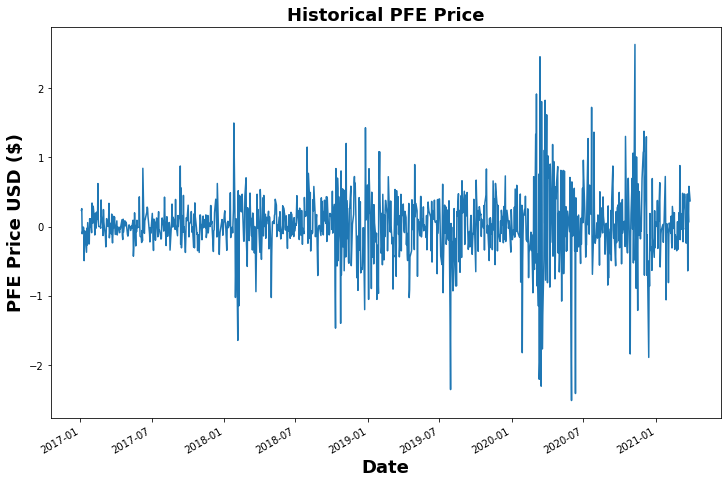

In [31]:
#price_change,
price_change_data = price_change_func(price_change,col1='Adj Close',stock_value='PFE')
price_change_data

The below graph shows that for the stated time the stock price difference was rarely positively more than $2.627 than negatviely more than -2.511.  The average daily return was 0.007375.<br>

In [32]:
#the mean (average) change was less than 1 cent
#absolute
price_change_1 = price_change.copy()
price_change_1['Actual_Changes'] = price_change_1['Actual_Changes'].abs() 
price_change_1['Actual_Changes'].describe()

count    1065.000000
mean        0.315001
std         0.356130
min         0.000000
25%         0.090616
50%         0.203510
75%         0.414135
max         2.627960
Name: Actual_Changes, dtype: float64

In [33]:
#single_plot(price_change, stock_value='Actual_Changes',stock_symbol='PFE')

In [34]:
#multi_stocks

In [35]:
multi_price_change = multi_stocks.copy()

MRNA, AZNA, JNJ didn't have a big daily price differece either psotively or negatively. NVAX did have spikes in daily price 
both psotively and negatively. NVAX average stock price is \\$41.94.  Around 2/21, the price spiked to 319.929 and 3.690000.  The price had increased \\$86.930 but then decreased \\$-34.299.<br>

In [36]:
def multi_price_change_func(data):
    data = data - data.shift(1)
    data.plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel('Price USD ($)',fontdict=label_font)
    plt.title('Multi-Stock Actual Changes',fontdict=label_font) 
    
    return data

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.234224,-0.169662,0.800001,NaN,0.186050,NaN
2017-01-05,0.258453,1.080444,0.199999,NaN,0.642715,NaN
2017-01-06,-0.104994,-0.500038,1.000000,NaN,-0.219879,NaN
2017-01-09,-0.008080,-0.017860,1.000000,NaN,0.084570,NaN
...,...,...,...,...,...,...
2021-03-23,-0.639999,-0.149994,-17.360001,-9.080002,-1.799999,-6.889999
2021-03-24,0.250000,1.559998,-19.599991,-4.910004,-0.610001,-6.059998
2021-03-25,0.059998,0.059998,-22.010010,1.720001,0.910000,1.079994


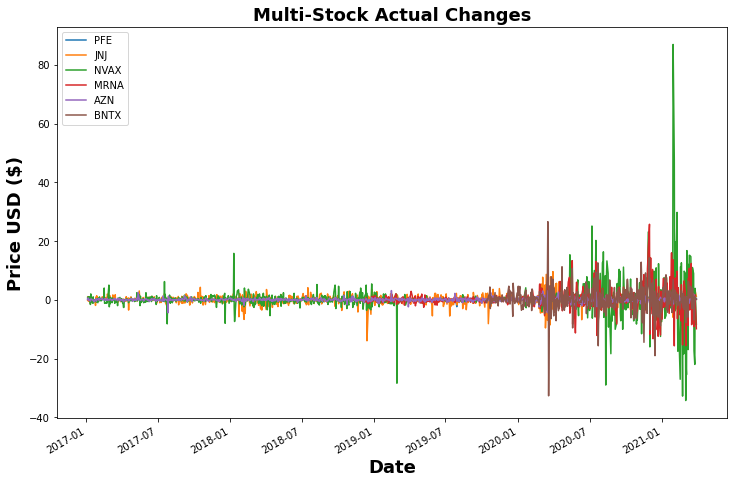

In [37]:
multi_price_calc = multi_price_change_func(multi_price_change)
multi_price_calc

In [38]:
multi_price_calc.describe()

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
count,1065.000000,1065.000000,1065.000000,579.000000,1065.000000,368.000000
mean,0.009358,0.058783,0.139296,0.181036,0.025706,0.221929
std,0.475458,1.723908,5.415717,3.707584,0.683872,4.631119
min,-2.511635,-13.964050,-34.299988,-15.680008,-4.421049,-32.700001
25%,-0.179653,-0.561020,-0.600000,-0.720001,-0.247993,-1.842497
50%,0.008781,0.083595,0.000000,0.020000,0.028324,0.125002
75%,0.218620,0.816727,0.799999,1.030000,0.304562,2.329998
max,2.627960,9.590652,86.930008,25.710007,3.912495,26.599998


In [39]:
def hist_func_actual(data, col=None):
    plt.figure(figsize=(12,8))
    data[col].hist(bins=50)
    plt.title('Histogram of Daily Returns Distribution')
    plt.xlabel('Actual Change')
    plt.ylabel('Frequency')

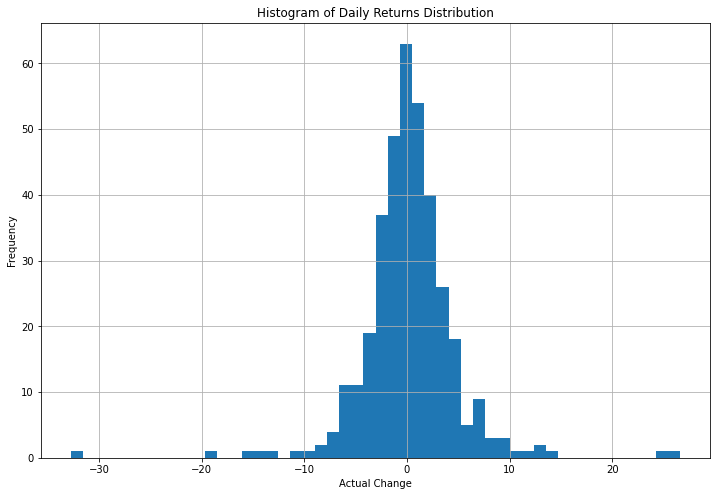

In [40]:
hist_func_actual(multi_price_calc, col='BNTX')

### Simple Daily Return
Daily price change as a percentage

In [41]:
multi_stocks.head()

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,26.653324,103.436539,25.400000,NaN,23.433638,NaN
2017-01-04,26.887548,103.266876,26.200001,NaN,23.619688,NaN
2017-01-05,27.146002,104.347321,26.400000,NaN,24.262403,NaN
2017-01-06,27.041008,103.847282,27.400000,NaN,24.042524,NaN
2017-01-09,27.032928,103.829422,28.400000,NaN,24.127094,NaN


In [42]:
(26.887548 /26.653324) -1

0.008787796974216056

In [43]:
#new price(cuurent time period) /old price - 1
#26.887548 - 26.653324=
#(26.200001 /25.400000) -1
def multi_price_change_func(data):
    daily_simple_returns = data.pct_change(1) #1 is for 1 day
    daily_simple_returns.plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel('Price USD ($)',fontdict=label_font)
    plt.title('Multi-Stock Actual Changes',fontdict=label_font) 
    
    return daily_simple_returns

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.008788,-0.001640,0.031496,NaN,0.007939,NaN
2017-01-05,0.009612,0.010463,0.007634,NaN,0.027211,NaN
2017-01-06,-0.003868,-0.004792,0.037879,NaN,-0.009063,NaN
2017-01-09,-0.000299,-0.000172,0.036496,NaN,0.003518,NaN
...,...,...,...,...,...,...
2021-03-23,-0.017778,-0.000935,-0.073187,-0.062363,-0.035156,-0.064393
2021-03-24,0.007070,0.009729,-0.089156,-0.035965,-0.012348,-0.060533
2021-03-25,0.001685,0.000371,-0.109918,0.013069,0.018651,0.011483


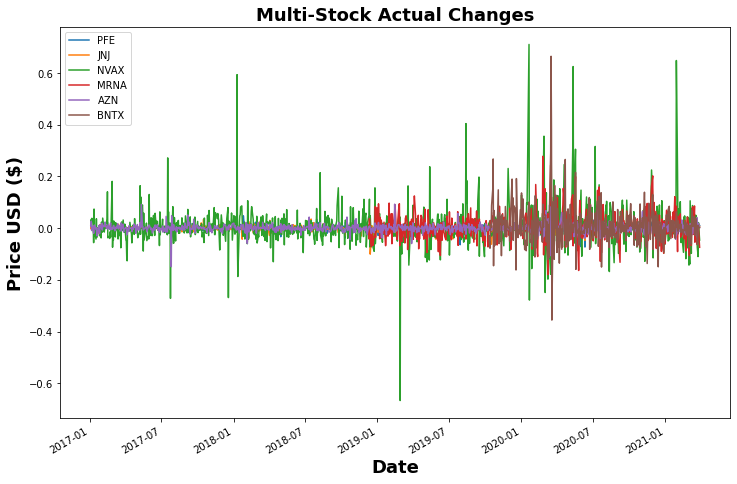

In [44]:
#percent change
#y % change
multi_dsr = multi_price_change_func(multi_stocks)
multi_dsr

In [45]:
#mean of daily simple return
#highest return should be NBTX and lowest for PFE
mean_dsr = multi_dsr.mean()
print('The Daily Mean Simple Return')
mean_dsr

The Daily Mean Simple Return


PFE     0.000402
JNJ     0.000532
NVAX    0.004685
MRNA    0.004605
AZN     0.000864
BNTX    0.007962
dtype: float64

In [46]:
def hist_func(data, col=None):
    plt.figure(figsize=(12,8))
    multi_dsr[col].hist(bins=50)
    plt.title('Histogram of Daily Returns Distribution')
    plt.xlabel('Daily Returns')
    plt.ylabel('Frequency')

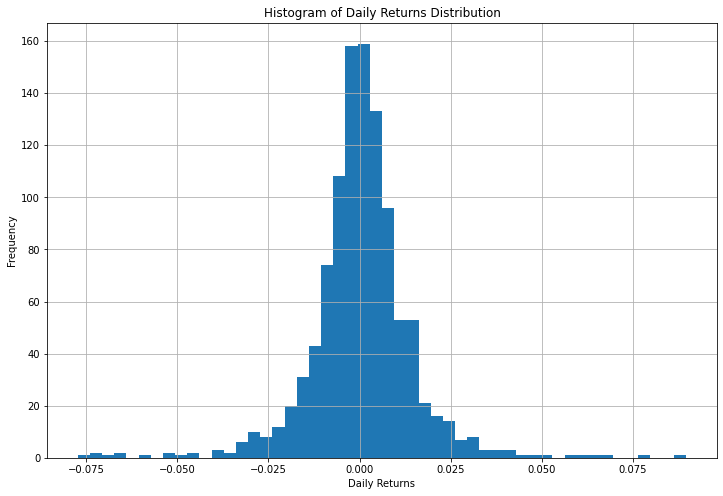

In [47]:
hist_func(multi_dsr, col='PFE')

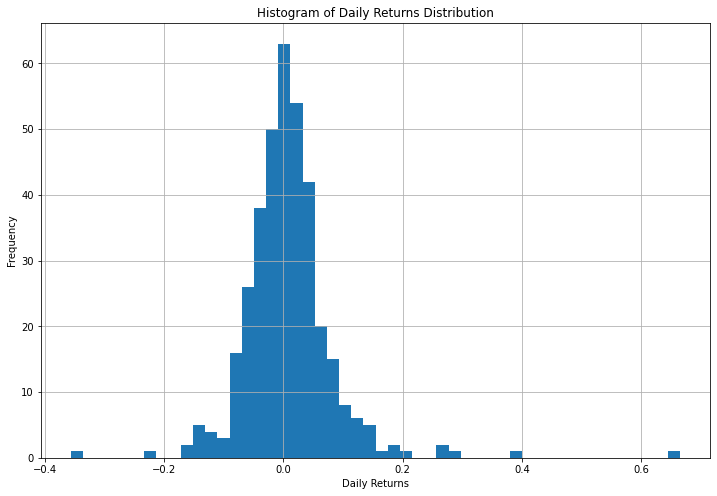

In [48]:
hist_func(multi_dsr, col='BNTX')

In [49]:
36.551258 - 37.603287

-1.0520290000000045

In [50]:
#stock volatility
#print standard deviaiton for daily simple return
#volatility is standard deviation
#Most volatile stock is NVAX, least volatile stock is JNJ
#the higher the volaitility the higher hte return, the lower volatility the lower return
#expect a lower return for JNJ as opposed to BNTX
#no absolute value, only abs when mean
#how different are thwy form each otehr
print('The Stock Volatility')
multi_dsr.std()

The Stock Volatility


PFE     0.014393
JNJ     0.013240
NVAX    0.077082
MRNA    0.052284
AZN     0.016493
BNTX    0.077117
dtype: float64

### Relative Strength Index (RSI)
The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100.  An asset is usually considered overbought when the value is above 70% and oversold when it is below 30%.  
https://www.investopedia.com/terms/r/rsi.asp Overbought refers that the bubble created from the buying might pop soon, and therefore the price will drop. This creates a strong entry point.  interpretation of the RSI is that values of 70 or above indicate that a security is becoming overvalued or overbought and may be due for a trend reversal or correction in price. An RSI value of 30 or below indicates an undervalued or oversold scenario.<br>
<br>
7/19-RSI value dips below 10 indicator, the 10 significant level.
    Tells us stock was oversold and presents a buying opportunity
On Adj Close plot was see that around 7/19 the price dipped from around \\$40.00 to \\$30.00.
    Then the price increased significantly again.
If you followed RSI you wuold have prucahsed around \\$30.00 and prcie jumped to \\$37.5 around 1/20.    

Around 7/18 to 9/18- Looks like stock was being over bought.  RSI value passed 80 level significant indicator.
    price was around \\$38.00 to \\$40.00.
    Pricde did drop to almost $35.00. Would have been a good time to drop prior to the drop.
    Would have saved some money from selling

In [51]:
rsi_df = pfe_stock_data.copy()
rsi_df

,Close,Volume,Adj Close
Date,,,
2017-01-03,31.309298,23391844.0,26.653324
2017-01-04,31.584440,22753963.0,26.887548
2017-01-05,31.888046,21083584.0,27.146002
2017-01-06,31.764706,18418228.0,27.041008
2017-01-09,31.755219,21559886.0,27.032928
...,...,...,...
2021-03-23,35.360001,27970500.0,35.360001
2021-03-24,35.610001,22883400.0,35.610001
2021-03-25,35.669998,24875300.0,35.669998


In [52]:
def rsi_function(data, col=None):
    rsi_d = data[col].diff(1)
    rsi_d = rsi_d.dropna()
    #get the postive gains (up) and negative gains(down)
    up = rsi_d.copy()
    down = rsi_d.copy()
    #get the postive values in delta
    up[up < 0]=0  #for any values in up that are less than 0. Any values n up that are less than 0, we'll set to 0
    down[down > 0]=0  #values in down that are greater than 0, they're positive. Set those values equal to 0.
    #up only contins positve values and down only contains negative values
    #Get the time period.  RSI is usually 14 day period
    period=14
    #calculate the average gain and average loss
    AVG_gain = up.rolling(window=period).mean()
    AVG_loss = abs(down.rolling(window=period).mean()) #going to be negative values so use absolute
    #calcualte RSI
    #calcualte relative strength (Rs)
    RS = AVG_gain / AVG_loss
    #calcualte relative strength Index (RSI)
    RSI = 100.0 - (100.0 / (1.0 + RS))
    #new dataframe
    new_df = pd.DataFrame()
    new_df[col] = rsi_df[col]
    new_df['RSI'] = RSI
    
    #plot column
    plt.figure(figsize=(12,8))
    plt.plot(new_df.index, new_df[col])
    plt.title(f'{col} Price History for Pfizer')
    plt.legend(new_df.columns.values, loc='upper left')
    #plot RSI values and signficant levels
    plt.figure(figsize=(12,8))
    plt.title('RSI')
    plt.plot(new_df.index,new_df['RSI'])
    plt.axhline(0, linestyle='--', alpha=0.5,color='gray')
    plt.axhline(10, linestyle='--', alpha=0.5,color='orange')
    plt.axhline(20, linestyle='--', alpha=0.5,color='green')
    plt.axhline(30, linestyle='--', alpha=0.5,color='red')
    plt.axhline(70, linestyle='--', alpha=0.5,color='red')
    plt.axhline(80, linestyle='--', alpha=0.5,color='green')
    plt.axhline(90, linestyle='--', alpha=0.5,color='orange')
    plt.axhline(100, linestyle='--', alpha=0.5,color='gray')
    
    return new_df

,Adj Close,RSI
Date,,
2017-01-03,26.653324,NaN
2017-01-04,26.887548,NaN
2017-01-05,27.146002,NaN
2017-01-06,27.041008,NaN
2017-01-09,27.032928,NaN
...,...,...
2021-03-23,35.360001,62.933323
2021-03-24,35.610001,68.503891
2021-03-25,35.669998,67.391250


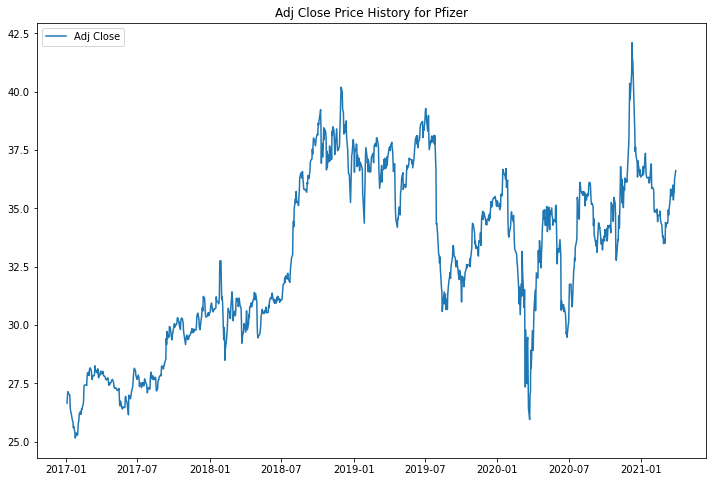

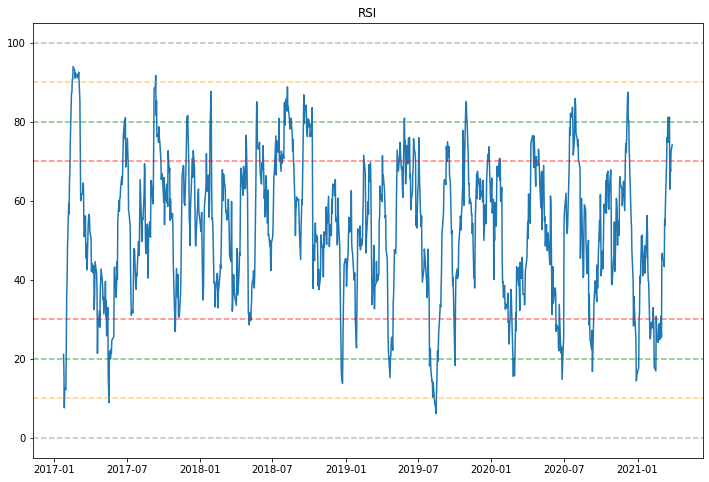

In [53]:
rsi_function(rsi_df, col='Adj Close')

## Question 2: How well do SARIMA algorithms perform with Adj Close column and Techinical Indicators in predictings future stocks prices? 
This section focuses on using SARIMA models to predict future stock prices.  Autoregressive Integrated Moving Average, or ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting.  Although the method can handle data with a trend, it does not support time series with a seasonal component.Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

In this section I will be working with univariate time series datasets.  I have created various functions which make it easy to just replace the symbol name to get a price prediction for another stock.  I am starting with the Pfizer then I will run the model with BVAX for a comparison.<br>
I created the function delta_data which allows me to add the calculations from Techincal Indicators section to the stock dataset I obtained from Datareader.  I will be working with the columns Adj Close, MA_50 and Actual_Changes.

To make the predicions I will be using One-Step ahead forecasting and Dynamic Forecasting. One Step Ahead static and dynamic forecasts are similar. The difference is with their estimation procedures. Dynamic forecast uses the value of the previous forecasted value of the dependent variable to compute the next one. On the other hand static forecast uses the actual value for each subsequent forecast.

<ins>Adj Close<ins>:<br>
The One Step Forecasting plot shows the confidence intervals 



In [54]:
#start='01-01-2019',end='today',
#df_single = single_stock_data('PFE', start='01-01-2019',end='today',plot=True,stock_value='Adj Close')

## Sarima Model

In [55]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

import statsmodels.api as sm

In [56]:
sarima_data = pfe_stock_data.copy()

#### Delta_data

In [57]:
def delta_data(data,col=None):
    data['Actual_Changes'] = data[col] - data[col].shift(1)
    data['Percent_Chg'] = data[col].pct_change(1)
    data['MA_50'] = data[col].rolling(50).mean()
    
    data = data.dropna()
    return data

In [58]:
sarima_df = delta_data(sarima_data,col='Adj Close')#delta_time_series(multi_stocks, col='Adj Close')

In [59]:
sarima_df

,Close,Volume,Adj Close,Actual_Changes,Percent_Chg,MA_50
Date,,,,,,
2017-03-15,32.855785,24279839.0,28.254789,0.334522,0.011981,26.801835
2017-03-16,32.666035,21816219.0,28.091606,-0.163183,-0.005775,26.830601
2017-03-17,32.561668,45736117.0,28.001856,-0.089750,-0.003195,26.852887
2017-03-20,32.618595,18435514.0,28.050808,0.048952,0.001748,26.870983
2017-03-21,32.495255,33083479.0,27.944742,-0.106066,-0.003781,26.889058
...,...,...,...,...,...,...
2021-03-23,35.360001,27970500.0,35.360001,-0.639999,-0.017778,35.190592
2021-03-24,35.610001,22883400.0,35.610001,0.250000,0.007070,35.155521
2021-03-25,35.669998,24875300.0,35.669998,0.059998,0.001685,35.133324


##### Train/Test Split

In [60]:
#training_data_len, dataset, scaler, scaled_data = preprocessing(df_data['Adj Close'], percentage=.8)
# n = int(len(sarima_df) * 0.8)
# train = sarima_df[:n]
# test = sarima_df[n:]

train = sarima_df[:int(0.8*(len(sarima_df)))]
test = sarima_df[int(0.8*(len(sarima_df))):]

In [61]:
len(sarima_df),len(train), len(test)

(1017, 813, 204)

In [62]:
test

,Close,Volume,Adj Close,Actual_Changes,Percent_Chg,MA_50
Date,,,,,,
2020-06-08,34.715370,30194149.0,33.663185,0.552010,0.016671,33.272776
2020-06-09,34.354839,21675088.0,33.313580,-0.349606,-0.010385,33.376091
2020-06-10,34.079697,29557217.0,33.046776,-0.266804,-0.008009,33.441824
2020-06-11,31.593927,63166642.0,30.636349,-2.410427,-0.072940,33.459894
2020-06-12,32.020874,37902472.0,31.050354,0.414005,0.013514,33.502459
...,...,...,...,...,...,...
2021-03-23,35.360001,27970500.0,35.360001,-0.639999,-0.017778,35.190592
2021-03-24,35.610001,22883400.0,35.610001,0.250000,0.007070,35.155521
2021-03-25,35.669998,24875300.0,35.669998,0.059998,0.001685,35.133324


##### ARIMA Model

In [63]:
def arima_model(df):
    """
    df- dataframe
    function is a gridsearch to get optimal p,d,qs and lowest AIC for the model.
    q-is moving average
    """
    autoarima_model = auto_arima(df, start_p = 0, start_q = 0, #start_q = 0
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = None,               # let model determine 'd', was 1
                              seasonal = True, 
                              start_P=0, D=1, trace = False, #start  #trace= True
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    #print('\n')
    #display(autoarima_model.summary())
    
    return autoarima_model


#### Pfizer / Adj Close

In [64]:
sarima_col = 'Adj Close'

In [65]:
#stepwise_fit = arima_model(train[sarima_col])

In [66]:
#stepwise_fit.summary()

In [67]:
arima_list = [['hist', 'pdq','seasonal_pdq','aic']] 
for col in sarima_df.columns:
  zip_test_2 = arima_model(sarima_df[col])
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

,hist,pdq,seasonal_pdq,aic
0,Close,"(3, 0, 0)","(1, 1, 1, 12)",1571.336406
1,Volume,"(2, 0, 1)","(1, 1, 2, 12)",35701.992956
2,Adj Close,"(3, 0, 0)","(1, 1, 1, 12)",1447.463413
3,Actual_Changes,"(1, 0, 3)","(1, 1, 1, 12)",1444.424992
4,Percent_Chg,"(0, 0, 0)","(1, 1, 1, 12)",-5578.549037
5,MA_50,"(2, 0, 0)","(0, 1, 1, 12)",-5754.350774


In [68]:
def fit_ARIMA(df, order=None, seasonal_order=None):
    """
    forecasting statsmodel SARIMAX model
    """
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    display(output.summary())
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    plt.show()
    
    return output

In [69]:
#train['Adj Close'][[0,-1]]
train[sarima_col][[0,-1]]

Date
2017-03-15    28.254789
2020-06-05    33.111176
Name: Adj Close, dtype: float64

In [70]:
#test['Adj Close'][[0,-1]]
test[sarima_col][[0,-1]]

Date
2020-06-08    33.663185
2021-03-29    36.619999
Name: Adj Close, dtype: float64

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Adj Close   No. Observations:                 1017
Model:             SARIMAX(3, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -711.529
Date:                              Mon, 29 Mar 2021   AIC                           1435.059
Time:                                      22:55:11   BIC                           1464.445
Sample:                                           0   HQIC                          1446.233
                                             - 1017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9240      0.019     48.331      0.000       0.887       0.962
ar.L2          0.1158      0.025      4.599      0.000       0.066       0.165
ar.L3         -0.0497      0.020     -2.486      0.013      -0.089      -0.011
ar.S.L12   -2.168e-06      0.025  -8.75e-05      1.000      -0.049       0.049
ma.S.L12      -1.0000     22.321     -0.045      0.964     -44.749      42.749
sigma2         0.2355      5.259      0.045      0.964     -10.071      10.543
===================================================================================
Ljung-Box (Q):                       91.58   Jarque-Bera (JB):              1190.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.82   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


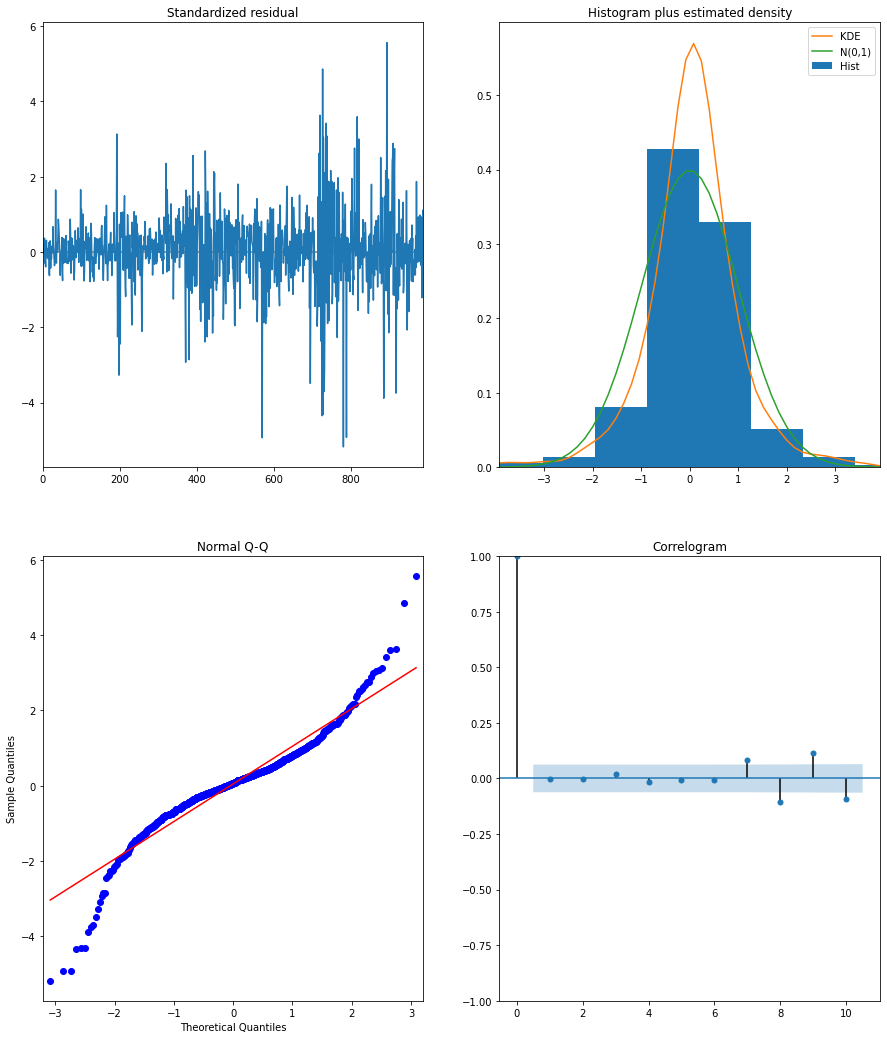

In [71]:
#one-step ahead
hist_type = sarima_col #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=False)
pred_conf = pred.conf_int()

In [72]:
#one_adj_c = 'Adj Close'
def one_step(train, test, one_adj_c, pred, pred_conf):
    plt.figure(figsize=(12,6))
    # Plot observed values

    #ax = train['Adj Close']['2019':].plot(label='observed')
    ax = train[one_adj_c ]['2019':].plot(label='observed')#
    #test['Adj Close']['2019':].plot()#label='Test'
    test[one_adj_c]['2019':].plot()#label='Test'
    # Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

    # Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=0.5)

    # Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Sale Price')
    plt.legend()

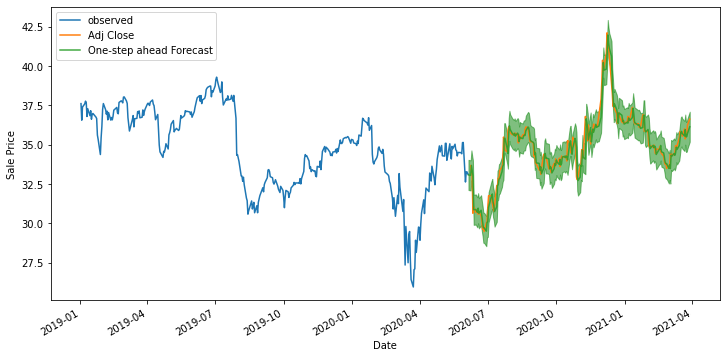

In [73]:
#re-run
#one_step_forecast = one_step(train, test, one_adj_c, pred,pred_conf)
one_step_forecast = one_step(train=train, test=test, one_adj_c='Adj Close', pred=pred,pred_conf=pred_conf)

In [74]:
def metric_func_one(pred, test, sarima_col):
    # Get the real and predicted values
    forecast = pred.predicted_mean
    actual =test[sarima_col]['1996':] #actual =test['Adj Close']['1996':]

    # Compute the root mean square error
    mse = ((forecast - actual) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    #np.sqrt(np.mean((predictions-targets)**2))
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [75]:
metric_func_one(pred, test, sarima_col)

The Mean Squared Error of our forecasts is 0.32
The Root Mean Squared Error of our forecasts is 0.56


/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Adj Close   No. Observations:                 1017
Model:             SARIMAX(3, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -711.529
Date:                              Mon, 29 Mar 2021   AIC                           1435.059
Time:                                      22:55:21   BIC                           1464.445
Sample:                                           0   HQIC                          1446.233
                                             - 1017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9240      0.019     48.331      0.000       0.887       0.962
ar.L2          0.1158      0.025      4.599      0.000       0.066       0.165
ar.L3         -0.0497      0.020     -2.486      0.013      -0.089      -0.011
ar.S.L12   -2.168e-06      0.025  -8.75e-05      1.000      -0.049       0.049
ma.S.L12      -1.0000     22.321     -0.045      0.964     -44.749      42.749
sigma2         0.2355      5.259      0.045      0.964     -10.071      10.543
===================================================================================
Ljung-Box (Q):                       91.58   Jarque-Bera (JB):              1190.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.82   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


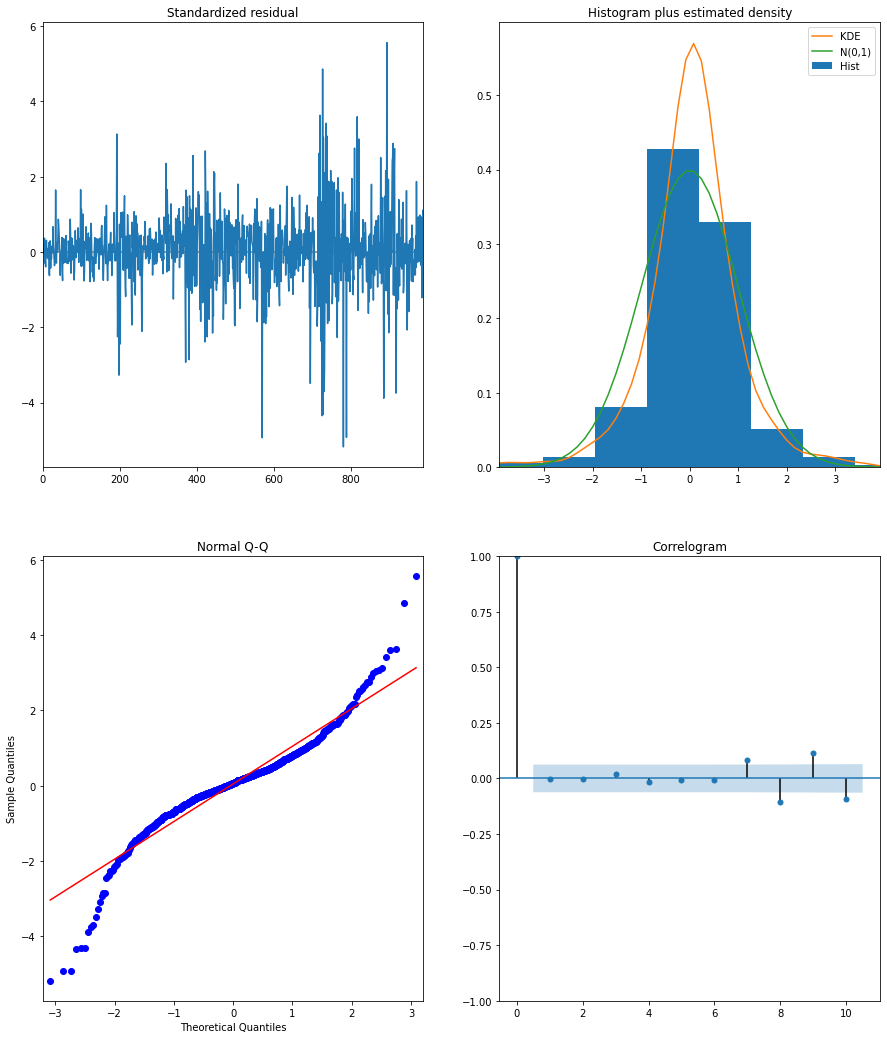

In [76]:
#dynamic forecasting
history_type = sarima_col #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [77]:
def prediction_vis(pred_dynamic,pred_dynamic_conf,train, one_adj_c,test):
    plt.figure(figsize=(12,6))
    # Plot observed values

    #ax = train['Adj Close']['2019':].plot(label='observed')
    ax = train[one_adj_c]['2019':].plot(label='observed')#
    #test['Adj Close']['2019':].plot()#label='Test'
    test[one_adj_c]['2019':].plot()#label='Test'
    # Plot predicted values
    pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

    # Plot the range for confidence intervals
    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

    # Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Sale Price')
    plt.legend()

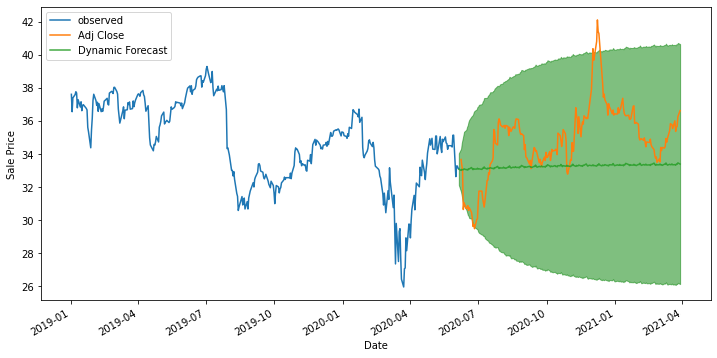

In [78]:
"""
test:
2020-11-02    33.657753
2021-03-25    35.410000
"""
#one_step_forecast = one_step(train=train, test=test, one_adj_c='Adj Close', pred=pred,pred_conf=pred_conf)
prediction_visual_1 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c='Adj Close')


In [79]:
"""
def metric_func(pred, test, sarima_col):
    # Get the real and predicted values
    forecast = pred.predicted_mean
    actual =test[sarima_col]['1996':] #actual =test['Adj Close']['1996':]

    # Compute the root mean square error
    mse = ((forecast - actual) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    #np.sqrt(np.mean((predictions-targets)**2))
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))


"""
def metric_func_dynamic(pred_dynamic, test, sarima_col):
# Get the real and predicted values
    forecast = pred_dynamic.predicted_mean
    actual = test[sarima_col]#['1996':] #history_type

    # Compute the mean square error
    mse = ((forecast - actual) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    #np.sqrt(np.mean((predictions-targets)**2))
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [81]:
metric_func_dynamic(pred_dynamic, test, sarima_col)

The Mean Squared Error of our forecasts is 7.12
The Root Mean Squared Error of our forecasts is 2.67


#### Pfizer / MA_50

In [82]:
sarima_col_1 = 'MA_50'

In [83]:
# #stepwise_fit = arima_model(train['Adj Close'])
# stepwise_fit = arima_model(train[sarima_col_1])

In [84]:
#stepwise_fit.summary()

In [85]:
arima_list = [['hist', 'pdq','seasonal_pdq','aic']] 
for col in sarima_df.columns:
  zip_test_2 = arima_model(sarima_df[col])
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

KeyboardInterrupt: 

In [ ]:
def fit_ARIMA(df, order=None, seasonal_order=None):
    """
    forecasting statsmodel SARIMAX model
    """
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    display(output.summary())
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    plt.show()
    
    return output

In [ ]:
#train['Adj Close'][[0,-1]]
train[sarima_col_1][[0,-1]]

In [ ]:
#test['Adj Close'][[0,-1]]
test[sarima_col_1][[0,-1]]

In [ ]:
hist_type = sarima_col_1 #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
#one_step_forecast = one_step(train, test, col_s = sarima_col,pred,pred_conf)
#one_step_forecast = one_step(train, test, one_adj_c ,pred,pred_conf)
# one_adj_c = 'MA_50'
# one_step_forecast_1 = one_step(train, test, one_adj_c,pred,pred_conf)
one_step_forecast_1 = one_step(train=train, test=test, one_adj_c='MA_50', pred=pred,pred_conf=pred_conf)

In [ ]:
metric_func_1 = metric_func_one(pred, test, sarima_col_1)

In [ ]:
history_type = sarima_col_1 #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
#prediction_visual_1 = prediction_vis(pred_dynamic,pred_dynamic_conf,train, s_col=sarima_col,test)
#one_adj_c = 'MA_50'
# prediction_visual_2 = prediction_vis(pred_dynamic,pred_dynamic_conf,train, one_adj_c,test)
# prediction_visual_2
prediction_visual_1 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c='MA_50')


In [ ]:
# # Get the real and predicted values
# forecast = pred_dynamic.predicted_mean
# actual = test[sarima_col_1]#['1996':]

# # Compute the mean square error
# mse = ((forecast - actual) ** 2).mean()
# print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
# #np.sqrt(np.mean((predictions-targets)**2))
# rmse = np.sqrt(np.mean((forecast - actual) ** 2))
# print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [ ]:
metric_func_dynamic(pred_dynamic, test, sarima_col_1)

#### Pfizer / Actual_Changes

In [ ]:
sarima_col_2 = 'Actual_Changes'

In [ ]:
#stepwise_fit1 = arima_model(train[sarima_col_2])

In [ ]:
#stepwise_fit1.summary()

In [ ]:
arima_list = [['hist', 'pdq','seasonal_pdq','aic']] 
for col in sarima_df.columns:
  zip_test_2 = arima_model(sarima_df[col])
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

In [ ]:
hist_type = sarima_col_2 #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
#col_s
#changei price
#price isn't didn't change much
#one_adj_c = 'Actual_Changes'
#one_step_forecast_2 = one_step(train, test, one_adj_c,pred,pred_conf)
one_step_forecast_2 = one_step(train=train, test=test, one_adj_c='Actual_Changes', pred=pred,pred_conf=pred_conf)

In [ ]:
#.57 more or less
metric_func_2 = metric_func_one(pred, test, sarima_col_2)

In [ ]:
history_type = sarima_col_2 #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
#s_col
#green confoience intervals
# one_adj_c = 'Actual_Changes'
# prediction_visual_3 = prediction_vis(pred_dynamic,pred_dynamic_conf,train, one_adj_c,test)
# prediction_visual_3
prediction_visual_3 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c='Actual_Changes')


In [ ]:
# # Get the real and predicted values
# forecast = pred_dynamic.predicted_mean
# actual = test[sarima_col_2]#['1996':]

# # Compute the mean square error
# mse = ((forecast - actual) ** 2).mean()
# print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
# #np.sqrt(np.mean((predictions-targets)**2))
# rmse = np.sqrt(np.mean((forecast - actual) ** 2))
# print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [ ]:
metric_func_dynamic(pred_dynamic, test, sarima_col_2)

#### BNTX

In [ ]:
start='01-01-2017'
end='today'
bntx_stock = single_stock_data('BNTX', start= start,end='today',plot=True,stock_value='Adj Close')
bntx_stock

In [ ]:
bntx_df = delta_data(bntx_stock,col='Adj Close')
train = bntx_df[:int(0.8*(len(bntx_df)))]
test = bntx_df[int(0.8*(len(bntx_df))):]

In [ ]:
train

In [ ]:
train.isna().sum()

In [ ]:
sarima_col_3 = 'Adj Close'

arima_list = [['hist', 'pdq','seasonal_pdq','aic']] 
for col in bntx_df.columns:
  zip_test_2 = arima_model(bntx_df[col])
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

In [ ]:
hist_type = sarima_col_3 #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(bntx_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
#blue actual
#green line is forecast
#orange-test 
#green shade confidence interval
#one_adj_c = 'Adj Close'
#one_step_forecast_4 = one_step(train, test, one_adj_c,pred,pred_conf)
one_step_forecast_4 = one_step(train=train, test=test, one_adj_c='Adj Close', pred=pred,pred_conf=pred_conf)

In [ ]:
#metric_func(pred, test,bntx_df)
#metric_func_2 = metric_func(pred, test, sarima_col_2)
metric_func_one(pred, test,sarima_col_3)

In [ ]:
history_type = sarima_col_3 #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(bntx_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
#gren line is forcast
#green shades gives more range for forecast
#one_adj_c = 'Adj Close'
# prediction_visual_3 = prediction_vis(pred_dynamic,pred_dynamic_conf,train, one_adj_c,test)
# prediction_visual_3
prediction_visual_4 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c='Adj Close')


In [ ]:
metric_func_dynamic(pred_dynamic, test, sarima_col_3):

#### MA_50

In [ ]:
sar_ma_50 = 'MA_50'

In [ ]:
hist_type = sar_ma_50  #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
one_step_forecast_5 = one_step(train=train, test=test, one_adj_c='MA_50', pred=pred,pred_conf=pred_conf)

In [ ]:
metric_func_one(pred, test, sar_ma_50)

In [ ]:
history_type = sar_ma_50 #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(bntx_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
prediction_visual_5 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c='MA_50')


In [ ]:
metric_func_dynamic(pred_dynamic, test, sar_ma_50):

### LTSM / Multi-Stocks


In [ ]:
multi_stocks

In [ ]:
def delta_time_series(data,col=None):
#     data['Actual_Changes'] = data['Close'] - data['Close'].shift(1)
#     data['Percent_Chg'] = data[col].pct_change(1)
#     data['MA_50'] = data[col].rolling(50).mean()
    data = data.dropna()
    return data

In [ ]:
multi = delta_time_series(multi_stocks, col='Adj Close')
multi

In [ ]:
multi.shape

In [ ]:
def plot_delta(data,col=None,symbol=None):
    #plt.figure(figsize=(12,6))
    #plt.plot(delta_time_series(data))
    data.plot(figsize=(12,6))
    label_font = {'weight':'bold','size':18}
    plt.title('Daily Percentage Price Change',fontdict=label_font)
    plt.xlabel('Dates',fontdict=label_font)
    plt.ylabel('close')
    plt.show()

In [ ]:
#simple daily return
#centered aroun d 0
plot_delta(multi)

In [ ]:
def get_y_from_df(train_scaled_df, look_back, col='PFE', ):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

#### Train Test Split

In [ ]:
train_size = int(len(multi) * 0.80)#0.67
test_size = len(multi) - train_size

In [ ]:
multi.index[train_size]

In [ ]:
multi.index[-test_size]


In [ ]:
def train_test_val(single_stock, date1='2020-09-11', date2='2020-11-01'):    
    train = single_stock[:date1]#'2020-09-11'
    val = single_stock[date1:date2]
    test = single_stock[date2:] #2021-02-12
    ax = train.plot(figsize=(12,8))
    val.plot(ax=ax)
    test.plot(ax=ax)
    
    return train, val, test

In [ ]:
train, val, test= train_test_val(multi)

#### Normalize Data

In [ ]:
def scale_function(train, test,val):
# normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    val_scaled = scaler.transform(val)
    
    return scaler, train_scaled,test_scaled, val_scaled

In [ ]:
scaler, train_scaled, test_scaled, val_scaled = scale_function(train,test,val)

In [ ]:
train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
val_scaled_df = pd.DataFrame(val_scaled, columns=val.columns, index=val.index)

In [ ]:
train_scaled_df.shape, val_scaled_df.shape, test_scaled_df.shape

In [ ]:
look_back = 3
batch_size=3
col_index = {v:k for k,v in enumerate(train_scaled_df.columns)}
col_index

In [ ]:
col_index['PFE']

#### Timeseries Generator

In [ ]:
def generator_function(train_scaled_df, val_scaled_df, test_scaled_df, col=None):
    train_data_gen = TimeseriesGenerator(train_scaled_df.values, train_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    val_data_gen = TimeseriesGenerator(val_scaled_df.values, val_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    test_data_gen = TimeseriesGenerator(test_scaled_df.values, test_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=3)
    
    ex_X, ex_y = train_data_gen[0]
    #ex_X.shape
    
    return train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y

In [ ]:
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='PFE')

In [ ]:
# ex_X, ex_y = train_data_gen[0]
# ex_X.shape

In [ ]:
sample = ex_X[0]
sample.shape

In [ ]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 25))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()    

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=True)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist = model.fit_generator(train_data_gen, epochs=25,validation_data=val_data_gen,callbacks=[early_stop])

In [ ]:
model.evaluate_generator(test_data_gen)

In [ ]:
pd.DataFrame(hist.history).plot()

In [ ]:
def save_model(model):
    model.save('model_parameters')
    model_params = keras.models.load_model('model_parameters')
    model_params.summary()

    return model_params

In [ ]:
# model_params = save_model(model)

In [ ]:
trainPredict = model.predict_generator(train_data_gen)
trainPredict.shape

In [ ]:
testPredict = model.predict_generator(test_data_gen)
testPredict.shape

In [ ]:
y_hat_train = pd.Series(trainPredict.flatten(),index=train.index[look_back:])
len(y_hat_train)

In [ ]:
#y_hat_train = pd.Series(testPredict.
y_hat_test = pd.Series(testPredict.flatten(),index=test.index[look_back:])
len(y_hat_test)

In [ ]:
y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

#### RMSE Function

In [ ]:
def model_metrics(y_train,y_hat_train):
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train, y_hat_train))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test, y_hat_test))
    print('Test Score: %.2f RMSE' % (testScore))
    
    return trainScore, testScore

In [ ]:
#a value of 0 means predcitions were exact
#models got values exactly as they were supposed to from testing data
#what in normalized
model_metrics(y_train,y_hat_train)

#### Prediction Plot

In [ ]:
#red what th model actually predicted
def prediction_plot(y_train,y_test,y_val,y_hat_test):
    plt.figure(figsize=(12,6))
    y_train.plot(label='train')
    y_test.plot(label='test')
    y_val.plot(label='val')
    y_hat_test.plot(label='Prediction')
    #lt.legend(['Valid','Train','Predictions'],loc='uppper left')
    plt.legend()
    

In [ ]:
prediction_plot(y_train,y_test,y_val,y_hat_test)

### LTSM / Single Stock

In [ ]:
#df_single.to_csv('single_stock')

# single = pd.read_csv('single_stock', parse_dates=True, index_col='Date')
# single

In [ ]:
# pfe_stock_data
pfe_stock_data

In [ ]:
def delta_time_series1(data,col=None):
    data['Actual_Changes'] = data['Close'] - data['Close'].shift(1)
    data['Percent_Chg'] = data[col].pct_change(1)
    data['MA_50'] = data[col].rolling(50).mean()
    data = data.dropna()
    return data

In [ ]:
single = delta_time_series1(pfe_stock_data, col='Adj Close')
single

In [ ]:
def get_y_from_df(train_scaled_df, look_back, col='Adj Close', ):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

In [ ]:
train_size = int(len(single) * 0.80)#0.67
test_size = len(single) - train_size

In [ ]:
def train_test_val(single_stock, date1='2020-09-11', date2='2020-11-01'):    
    train = single_stock[:date1]#'2020-09-11'
    val = single_stock[date1:date2]
    test = single_stock[date2:] #2021-02-12
    ax = train.plot()
    val.plot(ax=ax)
    test.plot(ax=ax)
    
    return train, val, test

In [ ]:
train, val, test= train_test_val(single)

In [ ]:
def scale_function(train, test,val):
# normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    val_scaled = scaler.transform(val)
    
    return scaler, train_scaled,test_scaled, val_scaled

In [ ]:
scaler, train_scaled, test_scaled, val_scaled = scale_function(train,test,val)

In [ ]:
train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
val_scaled_df = pd.DataFrame(val_scaled, columns=val.columns, index=val.index)

In [ ]:
train_scaled_df.shape, val_scaled_df.shape, test_scaled_df.shape

In [ ]:
look_back = 3
batch_size=3
col_index = {v:k for k,v in enumerate(train_scaled_df.columns)}
col_index

In [ ]:
def generator_function(train_scaled_df, val_scaled_df, test_scaled_df, col=None):
    train_data_gen = TimeseriesGenerator(train_scaled_df.values, train_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    val_data_gen = TimeseriesGenerator(val_scaled_df.values, val_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    test_data_gen = TimeseriesGenerator(test_scaled_df.values, test_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=3)
    
    ex_X, ex_y = train_data_gen[0]
    #ex_X.shape
    
    return train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y

In [ ]:
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='Adj Close')

In [ ]:
sample = ex_X[0]
sample.shape

In [ ]:
model1 = Sequential()

model1.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model1.add(Dropout(0.2))

model1.add(LSTM(units = 50, return_sequences = True))
model1.add(Dropout(0.2))

model1.add(LSTM(units = 50, return_sequences = False))
model1.add(Dropout(0.2))

model1.add(Dense(units = 25,activation='relu'))
model1.add(Dense(units = 1))

model1.compile(optimizer = 'adam', loss = 'mean_squared_error')

model1.summary()    

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=True)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist = model1.fit_generator(train_data_gen, epochs=25,validation_data=val_data_gen,callbacks=[early_stop])

In [ ]:
model1.evaluate_generator(test_data_gen)

In [ ]:
pd.DataFrame(hist.history).plot()

In [ ]:
trainPredict = model1.predict_generator(train_data_gen)
trainPredict.shape

In [ ]:
testPredict = model1.predict_generator(test_data_gen)
testPredict.shape

In [ ]:
y_hat_train = pd.Series(trainPredict.flatten(),index=train.index[look_back:])
len(y_hat_train)

In [ ]:
#y_hat_train = pd.Series(testPredict.
y_hat_test = pd.Series(testPredict.flatten(),index=test.index[look_back:])
len(y_hat_test)

In [ ]:
y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

In [ ]:
def model_metrics(y_train,y_hat_train):
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train, y_hat_train))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test, y_hat_test))
    print('Test Score: %.2f RMSE' % (testScore))
    
    return trainScore, testScore

In [ ]:
#what in normalized
model_metrics(y_train,y_hat_train)

In [ ]:
def prediction_plot(y_train,y_test,y_val,y_hat_test):
    plt.figure(figsize=(12,6))
    y_train.plot(label='train')
    y_test.plot(label='test')
    y_val.plot(label='val')
    y_hat_test.plot(label='Prediction')
    #lt.legend(['Valid','Train','Predictions'],loc='uppper left')
    plt.legend()
    

In [ ]:
prediction_plot(y_train,y_test,y_val,y_hat_test)

### LTSM and Technical Indicators

#### Moving Average 50 Days

In [ ]:
col_index['MA_50']

In [ ]:
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='MA_50')

In [ ]:
sample = ex_X[0]
sample.shape

In [ ]:
model2 = Sequential()

model2.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model2.add(Dropout(0.2))

model2.add(LSTM(units = 50, return_sequences = True))
model2.add(Dropout(0.2))

model2.add(LSTM(units = 50, return_sequences = False))
model2.add(Dropout(0.2))

model2.add(Dense(units = 25))
model2.add(Dense(units = 1))

model2.compile(optimizer = 'adam', loss = 'mean_squared_error')

model2.summary()    

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=True)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist = model2.fit_generator(train_data_gen, epochs=50,validation_data=val_data_gen,callbacks=[early_stop])

In [ ]:
model2.evaluate_generator(test_data_gen)

In [ ]:
pd.DataFrame(hist.history).plot()

In [ ]:
def get_y_from_df(train_scaled_df, look_back, col='MA_50'):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

In [ ]:
#look_back=3

In [ ]:
trainPredict = model2.predict_generator(train_data_gen)
#trainPredict.shape
testPredict = model2.predict_generator(test_data_gen)
#testPredict.shape
y_hat_train = pd.Series(trainPredict.flatten(),index=train_scaled_df.index[look_back:])
y_hat_test = pd.Series(testPredict.flatten(),index=test_scaled_df.index[look_back:])

y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

In [ ]:
model_metrics(y_train,y_hat_train)

In [ ]:
model_metrics(y_test,y_hat_test)

In [ ]:
# plt.figure(figsize=(12,6))
# y_train.plot(label='train')
# y_test.plot(label='test')
# y_val.plot(label='val')
# y_hat_test.plot(label='Prediction')
# #lt.legend(['Valid','Train','Predictions'],loc='uppper left')
# plt.legend()
prediction_plot(y_train,y_test,y_val,y_hat_test)

### Actual_Changes

In [ ]:
#dollar amount change
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='Actual_Changes')

In [ ]:
model3 = Sequential()

model3.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model3.add(Dropout(0.2))

model3.add(LSTM(units = 50, return_sequences = True))
model3.add(Dropout(0.2))

model3.add(LSTM(units = 50, return_sequences = False))
model3.add(Dropout(0.2))

model3.add(Dense(units = 25, activation='relu'))
model3.add(Dense(units = 1))

model3.compile(optimizer = 'adam', loss = 'mean_squared_error')

model3.summary()    

In [ ]:
hist = model3.fit_generator(train_data_gen, epochs=50,validation_data=val_data_gen,
                           callbacks=[early_stop])

In [ ]:
model3.evaluate_generator(test_data_gen)

In [ ]:
pd.DataFrame(hist.history).plot()

In [ ]:
def get_y_from_df(train_scaled_df, look_back, col='Actual_Changes'):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

In [ ]:
plt.plot(trainPredict)

In [ ]:
trainPredict = model3.predict_generator(train_data_gen)
#trainPredict.shape
testPredict = model3.predict_generator(test_data_gen)
#testPredict.shape
y_hat_train = pd.Series(trainPredict.flatten(),index=train_scaled_df.index[look_back:])
y_hat_test = pd.Series(testPredict.flatten(),index=test_scaled_df.index[look_back:])

y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

In [ ]:
model_metrics(y_train,y_hat_train)

In [ ]:
prediction_plot(y_train,y_test,y_val,y_hat_test)